This notebook is for machine state classification for GMM Dataset. Data preprocessing steps follow the notebook for anomaly detection. 

In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [4]:
dataset.describe()

,Timestep,Volt,Rotate,Pressure,Vibration,State
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1499.500000,0.373067,0.618286,0.228649,0.262340,1.670333
std,866.169729,0.059924,0.074675,0.062273,0.071261,1.305458
min,0.000000,0.205925,0.087729,0.089105,0.137005,0.000000
25%,749.750000,0.339570,0.608941,0.200876,0.227192,1.000000
50%,1499.500000,0.363052,0.634062,0.218191,0.249273,2.000000
75%,2249.250000,0.388709,0.657018,0.235343,0.272689,3.000000
max,2999.000000,0.849701,0.838351,0.739828,0.781317,5.000000


## Data Preprocessing and Cleaning

In [5]:
volt = np.array(dataset['Volt'].tolist()).transpose()
rotate = np.array(dataset['Rotate'].tolist()).transpose()
pressure = np.array(dataset['Pressure'].tolist()).transpose()
vibration = np.array(dataset['Vibration'].tolist()).transpose()
state = np.array(dataset['State'].tolist()).transpose()

In [6]:
dataset.isnull()

,Timestep,Volt,Rotate,Pressure,Vibration,State
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
2995,False,False,False,False,False,False
2996,False,False,False,False,False,False
2997,False,False,False,False,False,False
2998,False,False,False,False,False,False


In [7]:
dataset.isnull().sum()

Timestep     0
Volt         0
Rotate       0
Pressure     0
Vibration    0
State        0
dtype: int64

There are no null values in the dataset. Smoothing and scaling will not be used here since the sensor readings are already scaled when generated. Smoothing is not used here as each sensor reading belongs to a particular state and taking moving averages for smoothing may not be appropriate.

In [8]:
#Remove timestep and states from data
featuresDf = dataset.drop(columns=['Timestep', 'State'])

In [9]:
numReadings = len(featuresDf)
numTrain = int(0.6*numReadings)
numVal = int(0.2*numReadings)
train_dataset = featuresDf[0:numTrain]
val_dataset = featuresDf[numTrain:numTrain+numVal]
test_dataset = featuresDf[numTrain+numVal:]

#print number of readings in each set
print("number of readings in training set %d" % len(train_dataset))
print("number of readings in validation set %d" % len(val_dataset))
print("number of readings in test set %d" % len(test_dataset))

number of readings in training set 1800
number of readings in validation set 600
number of readings in test set 600


In [10]:
train_dataset

,Volt,Rotate,Pressure,Vibration
0,0.335098,0.630101,0.186233,0.276855
1,0.377602,0.712434,0.237875,0.225342
2,0.394153,0.603349,0.179491,0.273827
3,0.333236,0.608902,0.217711,0.211595
4,0.349643,0.707796,0.209827,0.245194
...,...,...,...,...
1795,0.333090,0.608943,0.251035,0.224175
1796,0.336812,0.644161,0.205314,0.275966
1797,0.317805,0.673133,0.197640,0.195530
1798,0.361077,0.645488,0.230087,0.231396


In [11]:
train_arr = train_dataset.to_numpy()
val_arr = val_dataset.to_numpy()
test_arr = test_dataset.to_numpy()

## Predicting machine states

In [12]:
Df = dataset.drop(columns=['Timestep'])

In [13]:
#regenerate data to include labels for state prediction
train_dataset = Df[0:numTrain]
val_dataset = Df[numTrain:numTrain+numVal]
test_dataset = Df[numTrain+numVal:]

In [14]:
#print number of readings in each set
print("number of readings in training set %d" % len(train_dataset))
print("number of readings in validation set %d" % len(val_dataset))
print("number of readings in test set %d" % len(test_dataset))

number of readings in training set 1800
number of readings in validation set 600
number of readings in test set 600


In [15]:
train_dataset

,Volt,Rotate,Pressure,Vibration,State
0,0.335098,0.630101,0.186233,0.276855,0
1,0.377602,0.712434,0.237875,0.225342,0
2,0.394153,0.603349,0.179491,0.273827,0
3,0.333236,0.608902,0.217711,0.211595,0
4,0.349643,0.707796,0.209827,0.245194,1
...,...,...,...,...,...
1795,0.333090,0.608943,0.251035,0.224175,1
1796,0.336812,0.644161,0.205314,0.275966,1
1797,0.317805,0.673133,0.197640,0.195530,1
1798,0.361077,0.645488,0.230087,0.231396,2


In [15]:
#for pycaret i will be merging training and validation sets together since the tuning is automated by the library itself. 

trainval_dataset = train_dataset.append(val_dataset)
print("number of readings in training and validation set %d" % len(trainval_dataset))

number of readings in training and validation set 2400


In [16]:
import pycaret
from pycaret.classification import *
from pycaret.classification import setup
from pycaret.classification import compare_models

y_trainval = trainval_dataset.columns[-1]

# setup the dataset
grid = setup(data=trainval_dataset, target=y_trainval, html=False, fold_shuffle=True, session_id=42, imputation_type='iterative')

# evaluate models and compare models
best = compare_models()
# report the best model
print(best)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Volt,Numeric
Rotate,Numeric
Pressure,Numeric
Vibration,Numeric
State,Label



Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target,State
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(2400, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.135,0.1535,0.811


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
svm,SVM - Linear Kernel,0.3032,0.0000,0.2580,0.2405,0.2099,0.1043,0.1416,0.032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
svm,SVM - Linear Kernel,0.3032,0.0000,0.2580,0.2405,0.2099,0.1043,0.1416,0.032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
svm,SVM - Linear Kernel,0.3032,0.0000,0.2580,0.2405,0.2099,0.1043,0.1416,0.032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
svm,SVM - Linear Kernel,0.3032,0.0000,0.2580,0.2405,0.2099,0.1043,0.1416,0.032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
ada,Ada Boost Classifier,0.3067,0.6085,0.2668,0.2483,0.2308,0.1063,0.1348,0.063
svm,SVM - Linear Kernel,0.3032,0.0000,0.2580,0.2405,0.2099,0.1043,0.1416,0.032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3680,0.6985,0.3364,0.3709,0.3661,0.1932,0.1942,0.508
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
ada,Ada Boost Classifier,0.3067,0.6085,0.2668,0.2483,0.2308,0.1063,0.1348,0.063
svm,SVM - Linear Kernel,0.3032,0.0000,0.2580,0.2405,0.2099,0.1043,0.1416,0.032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3680,0.6985,0.3364,0.3709,0.3661,0.1932,0.1942,0.508
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lda,Linear Discriminant Analysis,0.3448,0.6753,0.3047,0.3245,0.3140,0.1573,0.1640,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015
ada,Ada Boost Classifier,0.3067,0.6085,0.2668,0.2483,0.2308,0.1063,0.1348,0.063


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3680,0.6985,0.3364,0.3709,0.3661,0.1932,0.1942,0.508
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lda,Linear Discriminant Analysis,0.3448,0.6753,0.3047,0.3245,0.3140,0.1573,0.1640,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
et,Extra Trees Classifier,0.3383,0.6729,0.3077,0.3336,0.3331,0.1539,0.1546,0.288
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065
dt,Decision Tree Classifier,0.3085,0.5571,0.2906,0.3080,0.3064,0.1180,0.1184,0.015


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3680,0.6985,0.3364,0.3709,0.3661,0.1932,0.1942,0.508
xgboost,Extreme Gradient Boosting,0.3460,0.6826,0.3024,0.3464,0.3436,0.1630,0.1637,1.589
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lda,Linear Discriminant Analysis,0.3448,0.6753,0.3047,0.3245,0.3140,0.1573,0.1640,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
et,Extra Trees Classifier,0.3383,0.6729,0.3077,0.3336,0.3331,0.1539,0.1546,0.288
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313
knn,K Neighbors Classifier,0.3210,0.6393,0.2730,0.3215,0.3158,0.1264,0.1277,0.065


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3680,0.6985,0.3364,0.3709,0.3661,0.1932,0.1942,0.508
xgboost,Extreme Gradient Boosting,0.3460,0.6826,0.3024,0.3464,0.3436,0.1630,0.1637,1.589
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lda,Linear Discriminant Analysis,0.3448,0.6753,0.3047,0.3245,0.3140,0.1573,0.1640,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
et,Extra Trees Classifier,0.3383,0.6729,0.3077,0.3336,0.3331,0.1539,0.1546,0.288
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
lightgbm,Light Gradient Boosting Machine,0.3329,0.6732,0.2906,0.3287,0.3283,0.1460,0.1466,1.213
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.3680,0.6985,0.3364,0.3709,0.3661,0.1932,0.1942,0.508
xgboost,Extreme Gradient Boosting,0.3460,0.6826,0.3024,0.3464,0.3436,0.1630,0.1637,1.589
ridge,Ridge Classifier,0.3448,0.0000,0.2484,0.2909,0.2713,0.1417,0.1615,0.012
lda,Linear Discriminant Analysis,0.3448,0.6753,0.3047,0.3245,0.3140,0.1573,0.1640,0.012
lr,Logistic Regression,0.3413,0.6865,0.2442,0.2981,0.2724,0.1350,0.1535,0.811
et,Extra Trees Classifier,0.3383,0.6729,0.3077,0.3336,0.3331,0.1539,0.1546,0.288
nb,Naive Bayes,0.3353,0.6745,0.2736,0.3384,0.3074,0.1437,0.1542,0.012
qda,Quadratic Discriminant Analysis,0.3335,0.6786,0.2975,0.3364,0.3045,0.1488,0.1585,0.012
lightgbm,Light Gradient Boosting Machine,0.3329,0.6732,0.2906,0.3287,0.3283,0.1460,0.1466,1.213
rf,Random Forest Classifier,0.3246,0.6738,0.2859,0.3236,0.3213,0.1364,0.1371,0.313


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [17]:
#tune model
from sklearn.ensemble import GradientBoostingClassifier

# setup the dataset
grid = setup(data=trainval_dataset, target=y_trainval, html=False, silent=True, verbose=False)

# tune model hyperparameters
best_tune = tune_model(GradientBoostingClassifier(), n_iter=300)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 38.6min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 48.1min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3929,0.7196,0.3412,0.4033,0.3896,0.2177,0.2215
1,0.2738,0.6595,0.2433,0.2732,0.2680,0.0657,0.0666
2,0.3869,0.7204,0.3165,0.4036,0.3735,0.2067,0.2110
3,0.3214,0.6699,0.2991,0.3174,0.3170,0.1264,0.1271
4,0.3274,0.6800,0.2862,0.3256,0.3239,0.1355,0.1363
5,0.3631,0.6790,0.3224,0.3483,0.3494,0.1816,0.1838
6,0.3512,0.7181,0.2881,0.3496,0.3489,0.1687,0.1690
7,0.3155,0.6817,0.2715,0.3247,0.3175,0.1163,0.1168
8,0.3512,0.6594,0.3168,0.3528,0.3476,0.1675,0.1685
9,0.3234,0.6700,0.2826,0.3125,0.3105,0.1340,0.1356


In [18]:
print(best_tune)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=1,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=130,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Train with the parameters given the pycaret results 

In [89]:
from sklearn.ensemble import GradientBoostingClassifier

#prepare data

#training and validation set
train_y = np.array(trainval_dataset['State'].tolist())
featuresDf = trainval_dataset.drop(columns=['State'])
train_x = featuresDf.to_numpy()

#test set
test_y = np.array(test_dataset['State'].tolist())
featuresDf_test = test_dataset.drop(columns=['State'])
test_x = featuresDf_test.to_numpy()

clf33 = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=1,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.01, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=130,
                           n_iter_no_change=None,
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
clf33.fit(train_x, train_y)

#evaluate performance
accuracytrain = clf33.score(train_x, train_y)
print("accuracy on training and validation set is %f" % accuracytrain)

accuracy on training and validation set is 0.405833


Trying out artificial neural networks 

In [16]:
from sklearn.neural_network import MLPClassifier

#prepare training set 
train_y = np.array(train_dataset['State'].tolist())
featuresDf = train_dataset.drop(columns=['State'])
train_x = featuresDf.to_numpy()

#prepare validation set
val_y = np.array(val_dataset['State'].tolist())
featuresDf = val_dataset.drop(columns=['State'])
val_x = featuresDf.to_numpy()

#prepare test set
test_y = np.array(test_dataset['State'].tolist())
featuresDf = test_dataset.drop(columns=['State'])
test_x = featuresDf.to_numpy()

#train multilayer perceptron 
clf34 = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), 
                      random_state=42, max_iter=300, batch_size=32, 
                      shuffle=False, early_stopping=True)
clf34.fit(train_x, train_y)

#evaluate performance
accuracytrain = clf34.score(train_x, train_y)
print("accuracy on training set is %f" % accuracytrain)
accuracyval = clf34.score(val_x, val_y)
print("accuracy on validation set is %f" % accuracyval)

accuracy on training set is 0.376111
accuracy on validation set is 0.295000


Explore framing the machine state classification problem as a time series problem and explore various LSTM and CNN architectures. 

In [17]:
def splitData(dataX, dataY, timestep):
    output_x = []
    output_y = []
    for order in range(0, len(dataX)):
        #initialise 
        chunk = []
        
        #get chunk of x values 
        for i in range(0, timestep):
            chunk.append(dataX[order+i].tolist())
        
        #collate 
        num = order+timestep - 1
        output_x.append(chunk)
        output_y.append(dataY[num])
        
        #last chunk
        num_diff = len(dataX) - order
        if num_diff <= timestep:
            break
    
    output = [output_x, output_y]
    return output

In [18]:
#configure time series data 

interval = 10

#training set
train_data = splitData(train_x, train_y, interval)
Xtrain = np.array(train_data[0])
ytrain = np.array(train_data[1])

#validation set
val_data = splitData(val_x, val_y, interval)
Xval = np.array(val_data[0])
yval = np.array(val_data[1])

#test set
test_data = splitData(test_x, test_y, interval)
Xtest = np.array(test_data[0])
ytest = np.array(test_data[1])

In [111]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os

MODEL_NAME1 = 'model1_cnn1D.hd5'

model = models.Sequential()
model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu', input_shape=(10,4)))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [112]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 7, 128)            2176      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 64)             24640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 64)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 4, 32)             4128      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)             

In [113]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [114]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
savemodel = ModelCheckpoint(MODEL_NAME1)
stopmodel = EarlyStopping(min_delta=0.001, patience=10)

In [115]:
learning_model = model.fit(Xtrain, ytrain, epochs=200, batch_size=32, validation_data=(Xval,yval), callbacks=[savemodel, stopmodel])

Epoch 1/200
56/56 [==============================] - 2s 24ms/step - loss: 1.6294 - accuracy: 0.2328 - val_loss: 1.5970 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 2/200
56/56 [==============================] - 1s 19ms/step - loss: 1.6020 - accuracy: 0.2200 - val_loss: 1.6054 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 3/200
56/56 [==============================] - 2s 34ms/step - loss: 1.5994 - accuracy: 0.2250 - val_loss: 1.6109 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 4/200
56/56 [==============================] - 2s 33ms/step - loss: 1.5990 - accuracy: 0.2334 - val_loss: 1.5992 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 5/200
56/56 [==============================] - 2s 30ms/step - loss: 1.5977 - accuracy: 0.2591 - val_loss: 1.5959 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 6/200
56/56 [==============================] - 2s 28ms/step - loss: 1.5941 - accuracy: 0.2423 - val_loss: 1.5907 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 7/200
56/56 [==============================] - 1s 24ms/step - loss: 1.5881 - accuracy: 0.2423 - val_loss: 1.5962 - val_accuracy: 0.2826
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 8/200
56/56 [==============================] - 2s 30ms/step - loss: 1.5802 - accuracy: 0.2808 - val_loss: 1.5764 - val_accuracy: 0.3130
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 9/200
56/56 [==============================] - 1s 19ms/step - loss: 1.5552 - accuracy: 0.2998 - val_loss: 1.5624 - val_accuracy: 0.3519
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 10/200
56/56 [==============================] - 2s 27ms/step - loss: 1.5306 - accuracy: 0.3305 - val_loss: 1.5258 - val_accuracy: 0.3604
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 11/200
56/56 [==============================] - 2s 31ms/step - loss: 1.4839 - accuracy: 0.3640 - val_loss: 1.4957 - val_accuracy: 0.3503
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 12/200
56/56 [==============================] - 1s 18ms/step - loss: 1.4770 - accuracy: 0.3501 - val_loss: 1.4801 - val_accuracy: 0.3384
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 13/200
56/56 [==============================] - 1s 20ms/step - loss: 1.4472 - accuracy: 0.3791 - val_loss: 1.4716 - val_accuracy: 0.3841 0s - loss: 1.4430 - accu
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 14/200
56/56 [==============================] - 1s 25ms/step - loss: 1.4152 - accuracy: 0.3998 - val_loss: 1.4466 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 15/200
56/56 [==============================] - 2s 30ms/step - loss: 1.4002 - accuracy: 0.3970 - val_loss: 1.4325 - val_accuracy: 0.3790
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 16/200
56/56 [==============================] - 1s 24ms/step - loss: 1.3961 - accuracy: 0.3948 - val_loss: 1.4230 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 17/200
56/56 [==============================] - 1s 20ms/step - loss: 1.3641 - accuracy: 0.4255 - val_loss: 1.3951 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 18/200
56/56 [==============================] - 1s 18ms/step - loss: 1.3492 - accuracy: 0.4283 - val_loss: 1.4789 - val_accuracy: 0.3249
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 19/200
56/56 [==============================] - 1s 22ms/step - loss: 1.3622 - accuracy: 0.4054 - val_loss: 1.3534 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 20/200
56/56 [==============================] - 2s 27ms/step - loss: 1.3118 - accuracy: 0.4411 - val_loss: 1.3656 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 21/200
56/56 [==============================] - 1s 24ms/step - loss: 1.3030 - accuracy: 0.4495 - val_loss: 1.3205 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 22/200
56/56 [==============================] - 2s 27ms/step - loss: 1.3056 - accuracy: 0.4288 - val_loss: 1.3568 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 23/200
56/56 [==============================] - 1s 19ms/step - loss: 1.2820 - accuracy: 0.4467 - val_loss: 1.3111 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 24/200
56/56 [==============================] - 1s 26ms/step - loss: 1.2701 - accuracy: 0.4417 - val_loss: 1.2900 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 25/200
56/56 [==============================] - 2s 27ms/step - loss: 1.2675 - accuracy: 0.4478 - val_loss: 1.2739 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 26/200
56/56 [==============================] - 1s 26ms/step - loss: 1.2409 - accuracy: 0.4601 - val_loss: 1.2783 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 27/200
56/56 [==============================] - 2s 29ms/step - loss: 1.2287 - accuracy: 0.4696 - val_loss: 1.2864 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 28/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2305 - accuracy: 0.4629 - val_loss: 1.2821 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 29/200
56/56 [==============================] - 1s 25ms/step - loss: 1.2121 - accuracy: 0.4707 - val_loss: 1.2897 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 30/200
56/56 [==============================] - 1s 26ms/step - loss: 1.2281 - accuracy: 0.4534 - val_loss: 1.2571 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 31/200
56/56 [==============================] - 1s 21ms/step - loss: 1.2177 - accuracy: 0.4662 - val_loss: 1.2682 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 32/200
56/56 [==============================] - 1s 17ms/step - loss: 1.2182 - accuracy: 0.4590 - val_loss: 1.2766 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 33/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2395 - accuracy: 0.4573 - val_loss: 1.3036 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 34/200
56/56 [==============================] - 1s 16ms/step - loss: 1.1971 - accuracy: 0.4869 - val_loss: 1.2442 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 35/200
56/56 [==============================] - 1s 25ms/step - loss: 1.1845 - accuracy: 0.4763 - val_loss: 1.2542 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 36/200
56/56 [==============================] - 1s 18ms/step - loss: 1.1851 - accuracy: 0.4768 - val_loss: 1.2554 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 37/200
56/56 [==============================] - 1s 27ms/step - loss: 1.1791 - accuracy: 0.4679 - val_loss: 1.2807 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 38/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1842 - accuracy: 0.4841 - val_loss: 1.2645 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 39/200
56/56 [==============================] - 2s 35ms/step - loss: 1.1644 - accuracy: 0.4936 - val_loss: 1.2538 - val_accuracy: 0.4399 0s - loss: 1.1524 - accuracy
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 40/200
56/56 [==============================] - 2s 30ms/step - loss: 1.1623 - accuracy: 0.4835 - val_loss: 1.2877 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 41/200
56/56 [==============================] - 1s 23ms/step - loss: 1.1645 - accuracy: 0.4886 - val_loss: 1.2446 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 42/200
56/56 [==============================] - 2s 27ms/step - loss: 1.1384 - accuracy: 0.4953 - val_loss: 1.2634 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 43/200
56/56 [==============================] - 1s 17ms/step - loss: 1.1377 - accuracy: 0.5087 - val_loss: 1.2629 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


Epoch 44/200
56/56 [==============================] - 2s 29ms/step - loss: 1.1463 - accuracy: 0.4908 - val_loss: 1.2565 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


INFO:tensorflow:Assets written to: model1_cnn1D.hd5\assets


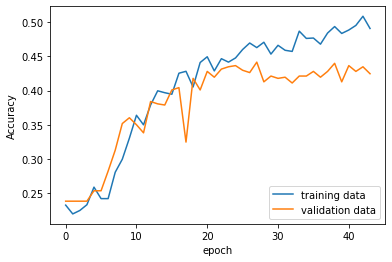

In [116]:
import matplotlib.pyplot as plt
plt.plot(learning_model.history['accuracy'])
plt.plot(learning_model.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [23]:
def mapResultsToClass(results):
    output = []
    for vector in results:
        output.append(np.argmax(vector))
    return output

In [118]:
#evaluation 
from sklearn.metrics import accuracy_score

#training set 
trainPredict = model.predict(Xtrain)
trainPredict = mapResultsToClass(trainPredict)
trainAccuracy = accuracy_score(ytrain, trainPredict)
print("Accuracy of training set %f" % trainAccuracy)

#validation set 
valPredict = model.predict(Xval)
valPredict = mapResultsToClass(valPredict)
valAccuracy = accuracy_score(yval, valPredict)
print("Accuracy of validation set %f" % valAccuracy)

Accuracy of training set 0.536013
Accuracy of validation set 0.424704


Try Stacked LSTM architecture

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

model2 = models.Sequential()
model2.add(layers.LSTM(128, activation='tanh', input_shape=(10,4), return_sequences=True))
model2.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model2.add(layers.LSTM(32, activation='tanh'))
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(6, activation='softmax'))

In [120]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 10, 128)           68096     
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 64)            49408     
_________________________________________________________________
lstm_23 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_23 (Dense)             (None, 6)                 606       
Total params: 133,826
Trainable params: 133,826
Non-trainable params: 0
_________________________________________________________________


In [121]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [122]:
model_name2 = 'model2_stackedLSTM.hd5'
savemodel = ModelCheckpoint(model_name2)
stopmodel = EarlyStopping(min_delta=0.001, patience=10)

In [123]:
learning_model2 = model2.fit(Xtrain, ytrain, epochs=200, batch_size=32, validation_data=(Xval,yval), callbacks=[savemodel, stopmodel])

Epoch 1/200
56/56 [==============================] - 21s 193ms/step - loss: 1.6426 - accuracy: 0.2317 - val_loss: 1.5937 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 2/200
56/56 [==============================] - 14s 259ms/step - loss: 1.6006 - accuracy: 0.2334 - val_loss: 1.6018 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 3/200
56/56 [==============================] - 14s 253ms/step - loss: 1.5948 - accuracy: 0.2406 - val_loss: 1.6091 - val_accuracy: 0.1760


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 4/200
56/56 [==============================] - 14s 244ms/step - loss: 1.5972 - accuracy: 0.2507 - val_loss: 1.5979 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 5/200
56/56 [==============================] - 16s 285ms/step - loss: 1.5948 - accuracy: 0.2245 - val_loss: 1.5847 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 6/200
56/56 [==============================] - 17s 311ms/step - loss: 1.5981 - accuracy: 0.2434 - val_loss: 1.5908 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 7/200
56/56 [==============================] - 15s 277ms/step - loss: 1.5940 - accuracy: 0.2328 - val_loss: 1.5913 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 8/200
56/56 [==============================] - 16s 281ms/step - loss: 1.5969 - accuracy: 0.2345 - val_loss: 1.5978 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 9/200
56/56 [==============================] - 14s 259ms/step - loss: 1.5952 - accuracy: 0.2317 - val_loss: 1.5928 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 10/200
56/56 [==============================] - 14s 259ms/step - loss: 1.5967 - accuracy: 0.2384 - val_loss: 1.5872 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 11/200
56/56 [==============================] - 14s 244ms/step - loss: 1.5952 - accuracy: 0.2451 - val_loss: 1.5968 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 12/200
56/56 [==============================] - 13s 235ms/step - loss: 1.5975 - accuracy: 0.2412 - val_loss: 1.5820 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 13/200
56/56 [==============================] - 15s 272ms/step - loss: 1.5954 - accuracy: 0.2423 - val_loss: 1.5886 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 14/200
56/56 [==============================] - 16s 282ms/step - loss: 1.5965 - accuracy: 0.2222 - val_loss: 1.5832 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 15/200
56/56 [==============================] - 15s 265ms/step - loss: 1.5949 - accuracy: 0.2412 - val_loss: 1.6005 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 16/200
56/56 [==============================] - 15s 263ms/step - loss: 1.5941 - accuracy: 0.2473 - val_loss: 1.5962 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 17/200
56/56 [==============================] - 15s 263ms/step - loss: 1.5939 - accuracy: 0.2434 - val_loss: 1.5949 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 18/200
56/56 [==============================] - 13s 227ms/step - loss: 1.5938 - accuracy: 0.2328 - val_loss: 1.5943 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 19/200
56/56 [==============================] - 13s 230ms/step - loss: 1.5942 - accuracy: 0.2334 - val_loss: 1.5985 - val_accuracy: 0.1760


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 20/200
56/56 [==============================] - 14s 255ms/step - loss: 1.5945 - accuracy: 0.2222 - val_loss: 1.5906 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 21/200
56/56 [==============================] - 15s 265ms/step - loss: 1.5942 - accuracy: 0.2540 - val_loss: 1.5924 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


Epoch 22/200
56/56 [==============================] - 14s 247ms/step - loss: 1.5941 - accuracy: 0.2300 - val_loss: 1.5947 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


INFO:tensorflow:Assets written to: model2_stackedLSTM.hd5\assets


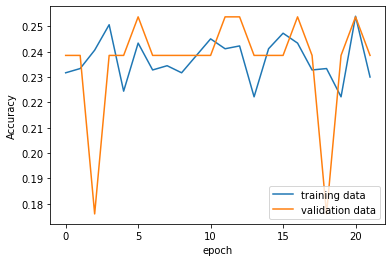

In [125]:
plt.plot(learning_model2.history['accuracy'])
plt.plot(learning_model2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [126]:
#evaluation 
from sklearn.metrics import accuracy_score

#training set 
trainPredict = model2.predict(Xtrain)
trainPredict = mapResultsToClass(trainPredict)
trainAccuracy = accuracy_score(ytrain, trainPredict)
print("Accuracy of training set %f" % trainAccuracy)

#validation set 
valPredict = model2.predict(Xval)
valPredict = mapResultsToClass(valPredict)
valAccuracy = accuracy_score(yval, valPredict)
print("Accuracy of validation set %f" % valAccuracy)

Accuracy of training set 0.247348
Accuracy of validation set 0.238579


Try CNN LSTM 

In [141]:
#reshape into [samples, subsequences, timesteps, features]
n_seq = 2
n_steps = 5
n_features = 4
Xtrain_subseq = Xtrain.reshape((Xtrain.shape[0], n_seq, n_steps, n_features))
Xval_subseq = Xval.reshape((Xval.shape[0], n_seq, n_steps, n_features))
Xtest_subseq = Xtest.reshape((Xtest.shape[0], n_seq, n_steps, n_features))

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

#create CNN-LSTM model
model3 = Sequential()
model3.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), input_shape=(None, n_steps, n_features)))
model3.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model3.add(TimeDistributed(Flatten()))
model3.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model3.add(layers.LSTM(32, activation='tanh'))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(6, activation='softmax'))

In [143]:
model3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, None, 2, 128)      2176      
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 1, 128)      0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 128)         0         
_________________________________________________________________
lstm_28 (LSTM)               (None, None, 64)          49408     
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_28 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_29 (Dense)             (None, 6)               

In [144]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [145]:
model_name3 = 'model3_CNN_LSTM.hd5'
savemodel = ModelCheckpoint(model_name3)
stopmodel = EarlyStopping(min_delta=0.001, patience=10)

In [146]:
learning_model3 = model3.fit(Xtrain_subseq, ytrain, epochs=200, batch_size=32, validation_data=(Xval_subseq,yval), callbacks=[savemodel, stopmodel])

Epoch 1/200
56/56 [==============================] - 8s 55ms/step - loss: 1.6665 - accuracy: 0.2217 - val_loss: 1.5873 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 2/200
56/56 [==============================] - 2s 27ms/step - loss: 1.5975 - accuracy: 0.2351 - val_loss: 1.5881 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 3/200
56/56 [==============================] - 2s 43ms/step - loss: 1.5943 - accuracy: 0.2312 - val_loss: 1.5865 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 4/200
56/56 [==============================] - 3s 47ms/step - loss: 1.5957 - accuracy: 0.2379 - val_loss: 1.5937 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 5/200
56/56 [==============================] - 2s 41ms/step - loss: 1.5940 - accuracy: 0.2434 - val_loss: 1.5834 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 6/200
56/56 [==============================] - 3s 56ms/step - loss: 1.5955 - accuracy: 0.2351 - val_loss: 1.5943 - val_accuracy: 0.1760


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 7/200
56/56 [==============================] - 2s 44ms/step - loss: 1.5961 - accuracy: 0.2317 - val_loss: 1.6000 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 8/200
56/56 [==============================] - 3s 54ms/step - loss: 1.5940 - accuracy: 0.2300 - val_loss: 1.5948 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 9/200
56/56 [==============================] - 3s 51ms/step - loss: 1.5950 - accuracy: 0.2345 - val_loss: 1.5928 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 10/200
56/56 [==============================] - 3s 55ms/step - loss: 1.5924 - accuracy: 0.2429 - val_loss: 1.5988 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 11/200
56/56 [==============================] - 3s 51ms/step - loss: 1.5908 - accuracy: 0.2284 - val_loss: 1.5814 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 12/200
56/56 [==============================] - 3s 55ms/step - loss: 1.5768 - accuracy: 0.2596 - val_loss: 1.5437 - val_accuracy: 0.2893


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 13/200
56/56 [==============================] - 3s 47ms/step - loss: 1.4934 - accuracy: 0.3093 - val_loss: 1.5103 - val_accuracy: 0.2217


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 14/200
56/56 [==============================] - 3s 52ms/step - loss: 1.4423 - accuracy: 0.3194 - val_loss: 1.4162 - val_accuracy: 0.3570


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 15/200
56/56 [==============================] - 3s 49ms/step - loss: 1.4483 - accuracy: 0.3116 - val_loss: 1.4681 - val_accuracy: 0.3164


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 16/200
56/56 [==============================] - 3s 56ms/step - loss: 1.4186 - accuracy: 0.3372 - val_loss: 1.4094 - val_accuracy: 0.3418


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 17/200
56/56 [==============================] - 4s 66ms/step - loss: 1.3977 - accuracy: 0.3389 - val_loss: 1.5247 - val_accuracy: 0.2893


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 18/200
56/56 [==============================] - 3s 62ms/step - loss: 1.4109 - accuracy: 0.3372 - val_loss: 1.4014 - val_accuracy: 0.3418


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 19/200
56/56 [==============================] - 3s 48ms/step - loss: 1.3879 - accuracy: 0.3367 - val_loss: 1.4087 - val_accuracy: 0.3367


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 20/200
56/56 [==============================] - 3s 56ms/step - loss: 1.3767 - accuracy: 0.3512 - val_loss: 1.3976 - val_accuracy: 0.3503


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 21/200
56/56 [==============================] - 3s 54ms/step - loss: 1.3742 - accuracy: 0.3534 - val_loss: 1.3941 - val_accuracy: 0.3723


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 22/200
56/56 [==============================] - 3s 56ms/step - loss: 1.3644 - accuracy: 0.3869 - val_loss: 1.3731 - val_accuracy: 0.3790


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 23/200
56/56 [==============================] - 3s 62ms/step - loss: 1.3386 - accuracy: 0.3892 - val_loss: 1.3853 - val_accuracy: 0.3452


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 24/200
56/56 [==============================] - 3s 62ms/step - loss: 1.3224 - accuracy: 0.3987 - val_loss: 1.3656 - val_accuracy: 0.3824


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 25/200
56/56 [==============================] - 4s 65ms/step - loss: 1.2894 - accuracy: 0.4210 - val_loss: 1.3683 - val_accuracy: 0.3993


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 26/200
56/56 [==============================] - 3s 46ms/step - loss: 1.2813 - accuracy: 0.4210 - val_loss: 1.3675 - val_accuracy: 0.3875


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 27/200
56/56 [==============================] - 3s 58ms/step - loss: 1.2712 - accuracy: 0.4204 - val_loss: 1.3757 - val_accuracy: 0.3976


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 28/200
56/56 [==============================] - 3s 55ms/step - loss: 1.2670 - accuracy: 0.4104 - val_loss: 1.3643 - val_accuracy: 0.4061


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 29/200
56/56 [==============================] - 3s 56ms/step - loss: 1.2482 - accuracy: 0.4389 - val_loss: 1.3561 - val_accuracy: 0.4027


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 30/200
56/56 [==============================] - 3s 62ms/step - loss: 1.2674 - accuracy: 0.4255 - val_loss: 1.4734 - val_accuracy: 0.3469


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 31/200
56/56 [==============================] - 3s 54ms/step - loss: 1.2705 - accuracy: 0.4283 - val_loss: 1.3281 - val_accuracy: 0.4146


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 32/200
56/56 [==============================] - 3s 55ms/step - loss: 1.2418 - accuracy: 0.4433 - val_loss: 1.3388 - val_accuracy: 0.4162


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 33/200
56/56 [==============================] - 3s 50ms/step - loss: 1.2360 - accuracy: 0.4517 - val_loss: 1.3757 - val_accuracy: 0.3959


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 34/200
56/56 [==============================] - 4s 67ms/step - loss: 1.2340 - accuracy: 0.4528 - val_loss: 1.3690 - val_accuracy: 0.3926


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 35/200
56/56 [==============================] - 4s 64ms/step - loss: 1.2167 - accuracy: 0.4578 - val_loss: 1.3739 - val_accuracy: 0.39421.2224 - ac - ETA: 0s - loss: 1.2212 - accuracy: 0.46 - ETA: 0s - loss: 1.2166 - accuracy:  - ETA: 0s - loss: 1


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 36/200
56/56 [==============================] - 3s 58ms/step - loss: 1.2102 - accuracy: 0.4500 - val_loss: 1.3302 - val_accuracy: 0.4010loss: 1.2104 - accuracy


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 37/200
56/56 [==============================] - 3s 63ms/step - loss: 1.2085 - accuracy: 0.4500 - val_loss: 1.3439 - val_accuracy: 0.4213


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 38/200
56/56 [==============================] - 3s 61ms/step - loss: 1.2020 - accuracy: 0.4562 - val_loss: 1.3473 - val_accuracy: 0.4095


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 39/200
56/56 [==============================] - 3s 49ms/step - loss: 1.2049 - accuracy: 0.4534 - val_loss: 1.3395 - val_accuracy: 0.4095


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 40/200
56/56 [==============================] - 4s 68ms/step - loss: 1.2011 - accuracy: 0.4584 - val_loss: 1.3349 - val_accuracy: 0.40952012 - accuracy: 0.45 - ETA: 0s - loss: 1.1993 - accuracy: 


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


Epoch 41/200
56/56 [==============================] - 4s 65ms/step - loss: 1.1814 - accuracy: 0.4757 - val_loss: 1.3575 - val_accuracy: 0.4061uracy:  - ETA: 1s - loss: 1.1905 - accura - ETA: 1s - loss: 1.1831 - ac - ETA: 0s - loss: 1


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


INFO:tensorflow:Assets written to: model3_CNN_LSTM.hd5\assets


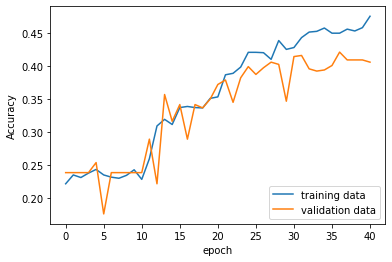

In [147]:
plt.plot(learning_model3.history['accuracy'])
plt.plot(learning_model3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [150]:
#evaluation 
from sklearn.metrics import accuracy_score

#training set 
trainPredict = model3.predict(Xtrain_subseq)
trainPredict = mapResultsToClass(trainPredict)
trainAccuracy = accuracy_score(ytrain, trainPredict)
print("Accuracy of training set %f" % trainAccuracy)

#validation set 
valPredict = model3.predict(Xval_subseq)
valPredict = mapResultsToClass(valPredict)
valAccuracy = accuracy_score(yval, valPredict)
print("Accuracy of validation set %f" % valAccuracy)

Accuracy of training set 0.485762
Accuracy of validation set 0.406091


Try ConvLSTM architecture 

In [151]:
#reshape into [samples, timesteps, rows, columns, features]
Xtrain_conv = Xtrain_subseq.reshape((Xtrain_subseq.shape[0], n_seq, 1, n_steps, n_features))
Xval_conv = Xval_subseq.reshape((Xval_subseq.shape[0], n_seq, 1, n_steps, n_features))
Xtest_conv = Xtest_subseq.reshape((Xtest.shape[0], n_seq, 1, n_steps, n_features))

In [152]:
from tensorflow.keras.layers import ConvLSTM2D

#create ConvLSTM model
model4 = Sequential()
model4.add(ConvLSTM2D(filters=128, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model4.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model4.add(TimeDistributed(Flatten()))
model4.add(layers.LSTM(64, activation='tanh', return_sequences=True))
model4.add(layers.LSTM(32, activation='tanh'))
model4.add(layers.Dense(100, activation='relu'))
model4.add(layers.Dense(6, activation='softmax'))

In [153]:
model4.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_5 (ConvLSTM2D)  (None, 1, 4, 128)         135680    
_________________________________________________________________
time_distributed_21 (TimeDis (None, 1, 2, 128)         0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 256)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 64)             82176     
_________________________________________________________________
lstm_31 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               3300      
_________________________________________________________________
dense_31 (Dense)             (None, 6)               

In [154]:
model4.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [155]:
model_name4 = 'model4_ConvLSTM.hd5'
savemodel = ModelCheckpoint(model_name4)
stopmodel = EarlyStopping(min_delta=0.001, patience=10)

In [156]:
learning_model4 = model4.fit(Xtrain_conv, ytrain, epochs=200, batch_size=32, validation_data=(Xval_conv,yval), callbacks=[savemodel, stopmodel])

Epoch 1/200
56/56 [==============================] - 27s 321ms/step - loss: 1.6309 - accuracy: 0.2535 - val_loss: 1.5849 - val_accuracy: 0.2538


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 2/200
56/56 [==============================] - 16s 287ms/step - loss: 1.5960 - accuracy: 0.2451 - val_loss: 1.5960 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 3/200
56/56 [==============================] - 16s 279ms/step - loss: 1.5952 - accuracy: 0.2395 - val_loss: 1.6100 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 4/200
56/56 [==============================] - 15s 267ms/step - loss: 1.5945 - accuracy: 0.2306 - val_loss: 1.5914 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 5/200
56/56 [==============================] - 16s 288ms/step - loss: 1.5942 - accuracy: 0.2434 - val_loss: 1.5923 - val_accuracy: 0.1760


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 6/200
56/56 [==============================] - 15s 274ms/step - loss: 1.5947 - accuracy: 0.2155 - val_loss: 1.5923 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 7/200
56/56 [==============================] - 15s 274ms/step - loss: 1.5950 - accuracy: 0.2473 - val_loss: 1.5924 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 8/200
56/56 [==============================] - 15s 271ms/step - loss: 1.5906 - accuracy: 0.2284 - val_loss: 1.5880 - val_accuracy: 0.2386


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 9/200
56/56 [==============================] - 15s 268ms/step - loss: 1.5478 - accuracy: 0.2440 - val_loss: 1.4337 - val_accuracy: 0.3316


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 10/200
56/56 [==============================] - 15s 261ms/step - loss: 1.4148 - accuracy: 0.3127 - val_loss: 1.3890 - val_accuracy: 0.3299


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 11/200
56/56 [==============================] - 17s 309ms/step - loss: 1.3809 - accuracy: 0.3333 - val_loss: 1.3744 - val_accuracy: 0.3316


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 12/200
56/56 [==============================] - 18s 328ms/step - loss: 1.3814 - accuracy: 0.3076 - val_loss: 1.3845 - val_accuracy: 0.3198


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 13/200
56/56 [==============================] - 14s 254ms/step - loss: 1.3687 - accuracy: 0.3283 - val_loss: 1.3704 - val_accuracy: 0.3587


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 14/200
56/56 [==============================] - 16s 288ms/step - loss: 1.3602 - accuracy: 0.3339 - val_loss: 1.3679 - val_accuracy: 0.3384


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 15/200
56/56 [==============================] - 15s 268ms/step - loss: 1.3585 - accuracy: 0.3361 - val_loss: 1.3785 - val_accuracy: 0.3689


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 16/200
56/56 [==============================] - 16s 278ms/step - loss: 1.3534 - accuracy: 0.3573 - val_loss: 1.3664 - val_accuracy: 0.3283


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 17/200
56/56 [==============================] - 15s 269ms/step - loss: 1.3490 - accuracy: 0.3501 - val_loss: 1.3723 - val_accuracy: 0.3519


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 18/200
56/56 [==============================] - 15s 275ms/step - loss: 1.3440 - accuracy: 0.3534 - val_loss: 1.3621 - val_accuracy: 0.3723


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 19/200
56/56 [==============================] - 16s 288ms/step - loss: 1.3308 - accuracy: 0.4009 - val_loss: 1.3612 - val_accuracy: 0.3519


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 20/200
56/56 [==============================] - 17s 304ms/step - loss: 1.3073 - accuracy: 0.3992 - val_loss: 1.3456 - val_accuracy: 0.3807


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 21/200
56/56 [==============================] - 11s 191ms/step - loss: 1.3024 - accuracy: 0.4009 - val_loss: 1.3417 - val_accuracy: 0.3875


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 22/200
56/56 [==============================] - 14s 249ms/step - loss: 1.2780 - accuracy: 0.4171 - val_loss: 1.3476 - val_accuracy: 0.3807


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 23/200
56/56 [==============================] - 13s 242ms/step - loss: 1.2694 - accuracy: 0.4232 - val_loss: 1.3568 - val_accuracy: 0.3858


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 24/200
56/56 [==============================] - 14s 248ms/step - loss: 1.2737 - accuracy: 0.4232 - val_loss: 1.3293 - val_accuracy: 0.4095


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 25/200
56/56 [==============================] - 15s 261ms/step - loss: 1.2437 - accuracy: 0.4389 - val_loss: 1.3332 - val_accuracy: 0.3824


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 26/200
56/56 [==============================] - 14s 249ms/step - loss: 1.2417 - accuracy: 0.4299 - val_loss: 1.3257 - val_accuracy: 0.4179


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 27/200
56/56 [==============================] - 13s 228ms/step - loss: 1.2328 - accuracy: 0.4305 - val_loss: 1.3412 - val_accuracy: 0.4061


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 28/200
56/56 [==============================] - 17s 301ms/step - loss: 1.2343 - accuracy: 0.4316 - val_loss: 1.3264 - val_accuracy: 0.4044


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 29/200
56/56 [==============================] - 16s 283ms/step - loss: 1.2345 - accuracy: 0.4322 - val_loss: 1.3326 - val_accuracy: 0.3959


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 30/200
56/56 [==============================] - 16s 281ms/step - loss: 1.2140 - accuracy: 0.4456 - val_loss: 1.3323 - val_accuracy: 0.3875


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 31/200
56/56 [==============================] - 14s 258ms/step - loss: 1.2119 - accuracy: 0.4472 - val_loss: 1.3593 - val_accuracy: 0.3926


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 32/200
56/56 [==============================] - 16s 280ms/step - loss: 1.2156 - accuracy: 0.4428 - val_loss: 1.3330 - val_accuracy: 0.4010


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 33/200
56/56 [==============================] - 16s 282ms/step - loss: 1.2059 - accuracy: 0.4523 - val_loss: 1.3424 - val_accuracy: 0.3858


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 34/200
56/56 [==============================] - 14s 245ms/step - loss: 1.1982 - accuracy: 0.4523 - val_loss: 1.3245 - val_accuracy: 0.4061


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 35/200
56/56 [==============================] - 15s 277ms/step - loss: 1.2022 - accuracy: 0.4400 - val_loss: 1.3281 - val_accuracy: 0.4196


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 36/200
56/56 [==============================] - 17s 301ms/step - loss: 1.2089 - accuracy: 0.4545 - val_loss: 1.3285 - val_accuracy: 0.3909


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 37/200
56/56 [==============================] - 12s 217ms/step - loss: 1.1862 - accuracy: 0.4612 - val_loss: 1.3199 - val_accuracy: 0.4044


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 38/200
56/56 [==============================] - 15s 275ms/step - loss: 1.1908 - accuracy: 0.4545 - val_loss: 1.3351 - val_accuracy: 0.3993


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 39/200
56/56 [==============================] - 15s 275ms/step - loss: 1.1819 - accuracy: 0.4567 - val_loss: 1.3505 - val_accuracy: 0.4027


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 40/200
56/56 [==============================] - 15s 273ms/step - loss: 1.1800 - accuracy: 0.4500 - val_loss: 1.3284 - val_accuracy: 0.3892


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 41/200
56/56 [==============================] - 14s 248ms/step - loss: 1.1747 - accuracy: 0.4606 - val_loss: 1.3463 - val_accuracy: 0.3976


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 42/200
56/56 [==============================] - 14s 257ms/step - loss: 1.1704 - accuracy: 0.4668 - val_loss: 1.3379 - val_accuracy: 0.4315


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 43/200
56/56 [==============================] - 15s 278ms/step - loss: 1.1668 - accuracy: 0.4623 - val_loss: 1.3519 - val_accuracy: 0.4095


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 44/200
56/56 [==============================] - 14s 246ms/step - loss: 1.1747 - accuracy: 0.4685 - val_loss: 1.3577 - val_accuracy: 0.4146


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 45/200
56/56 [==============================] - 14s 258ms/step - loss: 1.1685 - accuracy: 0.4645 - val_loss: 1.3405 - val_accuracy: 0.4027


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 46/200
56/56 [==============================] - 16s 289ms/step - loss: 1.1667 - accuracy: 0.4662 - val_loss: 1.3587 - val_accuracy: 0.4044


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


Epoch 47/200
56/56 [==============================] - 14s 255ms/step - loss: 1.1635 - accuracy: 0.4679 - val_loss: 1.3522 - val_accuracy: 0.3858


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


INFO:tensorflow:Assets written to: model4_ConvLSTM.hd5\assets


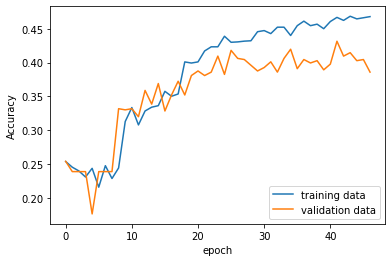

In [157]:
plt.plot(learning_model4.history['accuracy'])
plt.plot(learning_model4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [159]:
#training set 
trainPredict = model4.predict(Xtrain_conv)
trainPredict = mapResultsToClass(trainPredict)
trainAccuracy = accuracy_score(ytrain, trainPredict)
print("Accuracy of training set %f" % trainAccuracy)

#validation set 
valPredict = model4.predict(Xval_conv)
valPredict = mapResultsToClass(valPredict)
valAccuracy = accuracy_score(yval, valPredict)
print("Accuracy of validation set %f" % valAccuracy)

Accuracy of training set 0.470687
Accuracy of validation set 0.385787


1 dimensional CNN seems to give the best performance. 

## Hyperparameter tuning

Change number of filters in each convolutional layer while keeping number of convolutional layers constant. 

Epoch 1/200
56/56 [==============================] - 3s 45ms/step - loss: 1.6202 - accuracy: 0.2373 - val_loss: 1.6209 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 2/200
56/56 [==============================] - 2s 42ms/step - loss: 1.5976 - accuracy: 0.2440 - val_loss: 1.5912 - val_accuracy: 0.2944
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 3/200
56/56 [==============================] - 2s 43ms/step - loss: 1.5940 - accuracy: 0.2557 - val_loss: 1.6045 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 4/200
56/56 [==============================] - 2s 42ms/step - loss: 1.5891 - accuracy: 0.2485 - val_loss: 1.5819 - val_accuracy: 0.2487
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 5/200
56/56 [==============================] - 2s 42ms/step - loss: 1.5632 - accuracy: 0.2920 - val_loss: 1.5231 - val_accuracy: 0.3469
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 6/200
56/56 [==============================] - 2s 42ms/step - loss: 1.5128 - accuracy: 0.3372 - val_loss: 1.4889 - val_accuracy: 0.3638
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 7/200
56/56 [==============================] - 2s 42ms/step - loss: 1.4576 - accuracy: 0.3802 - val_loss: 1.4389 - val_accuracy: 0.3756
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 8/200
56/56 [==============================] - 2s 42ms/step - loss: 1.4204 - accuracy: 0.3786 - val_loss: 1.4151 - val_accuracy: 0.3858
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 9/200
56/56 [==============================] - 2s 42ms/step - loss: 1.3739 - accuracy: 0.3975 - val_loss: 1.4371 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 10/200
56/56 [==============================] - 2s 42ms/step - loss: 1.3521 - accuracy: 0.4243 - val_loss: 1.3435 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 11/200
56/56 [==============================] - 2s 42ms/step - loss: 1.3160 - accuracy: 0.4182 - val_loss: 1.3085 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 12/200
56/56 [==============================] - 2s 42ms/step - loss: 1.2975 - accuracy: 0.4472 - val_loss: 1.3370 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 13/200
56/56 [==============================] - 2s 42ms/step - loss: 1.2838 - accuracy: 0.4467 - val_loss: 1.3164 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 14/200
56/56 [==============================] - 2s 43ms/step - loss: 1.2739 - accuracy: 0.4394 - val_loss: 1.2858 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 15/200
56/56 [==============================] - 2s 42ms/step - loss: 1.2668 - accuracy: 0.4534 - val_loss: 1.2747 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 16/200
56/56 [==============================] - 2s 42ms/step - loss: 1.2261 - accuracy: 0.4640 - val_loss: 1.2575 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 17/200
56/56 [==============================] - 2s 41ms/step - loss: 1.2388 - accuracy: 0.4495 - val_loss: 1.2546 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 18/200
56/56 [==============================] - 3s 46ms/step - loss: 1.2219 - accuracy: 0.4651 - val_loss: 1.2522 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 19/200
56/56 [==============================] - 2s 44ms/step - loss: 1.2333 - accuracy: 0.4551 - val_loss: 1.2644 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 20/200
56/56 [==============================] - 2s 44ms/step - loss: 1.2089 - accuracy: 0.4701 - val_loss: 1.2646 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 21/200
56/56 [==============================] - 2s 40ms/step - loss: 1.2071 - accuracy: 0.4690 - val_loss: 1.2465 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 22/200
56/56 [==============================] - 2s 40ms/step - loss: 1.1862 - accuracy: 0.4673 - val_loss: 1.2496 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 23/200
56/56 [==============================] - 2s 44ms/step - loss: 1.1728 - accuracy: 0.4886 - val_loss: 1.2414 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 24/200
56/56 [==============================] - 2s 43ms/step - loss: 1.1677 - accuracy: 0.4880 - val_loss: 1.2485 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 25/200
56/56 [==============================] - 2s 41ms/step - loss: 1.1715 - accuracy: 0.4768 - val_loss: 1.2398 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 26/200
56/56 [==============================] - 2s 44ms/step - loss: 1.1631 - accuracy: 0.4796 - val_loss: 1.2372 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 27/200
56/56 [==============================] - 3s 47ms/step - loss: 1.1451 - accuracy: 0.4830 - val_loss: 1.2536 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 28/200
56/56 [==============================] - 3s 48ms/step - loss: 1.1327 - accuracy: 0.4886 - val_loss: 1.2496 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 29/200
56/56 [==============================] - 2s 42ms/step - loss: 1.1452 - accuracy: 0.4930 - val_loss: 1.2757 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 30/200
56/56 [==============================] - 2s 40ms/step - loss: 1.1296 - accuracy: 0.5020 - val_loss: 1.2746 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 31/200
56/56 [==============================] - 2s 40ms/step - loss: 1.1174 - accuracy: 0.4975 - val_loss: 1.2606 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 32/200
56/56 [==============================] - 2s 42ms/step - loss: 1.1269 - accuracy: 0.5126 - val_loss: 1.2486 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 33/200
56/56 [==============================] - 2s 43ms/step - loss: 1.1163 - accuracy: 0.5053 - val_loss: 1.2549 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 34/200
56/56 [==============================] - 2s 41ms/step - loss: 1.1097 - accuracy: 0.5092 - val_loss: 1.2531 - val_accuracy: 0.3959
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 35/200
56/56 [==============================] - 2s 40ms/step - loss: 1.0967 - accuracy: 0.4891 - val_loss: 1.2778 - val_accuracy: 0.3909
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 36/200
56/56 [==============================] - 2s 40ms/step - loss: 1.0917 - accuracy: 0.5154 - val_loss: 1.2467 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


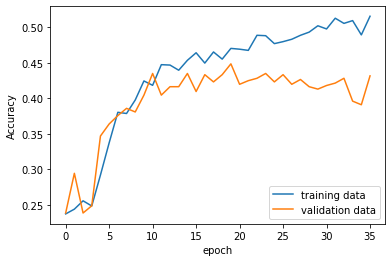

Accuracy of training set 0.534338
Accuracy of validation set 0.431472
Epoch 1/200
56/56 [==============================] - 2s 26ms/step - loss: 1.6399 - accuracy: 0.2300 - val_loss: 1.6126 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 2/200
56/56 [==============================] - 1s 22ms/step - loss: 1.6047 - accuracy: 0.2345 - val_loss: 1.5993 - val_accuracy: 0.1963
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 3/200
56/56 [==============================] - 1s 22ms/step - loss: 1.6001 - accuracy: 0.2334 - val_loss: 1.6065 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 4/200
56/56 [==============================] - 1s 21ms/step - loss: 1.6000 - accuracy: 0.2501 - val_loss: 1.5943 - val_accuracy: 0.3147
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 5/200
56/56 [==============================] - 1s 22ms/step - loss: 1.5934 - accuracy: 0.2540 - val_loss: 1.6009 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 6/200
56/56 [==============================] - 1s 22ms/step - loss: 1.5862 - accuracy: 0.2641 - val_loss: 1.5906 - val_accuracy: 0.2470
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 7/200
56/56 [==============================] - 1s 22ms/step - loss: 1.5704 - accuracy: 0.3015 - val_loss: 1.5531 - val_accuracy: 0.3283
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 8/200
56/56 [==============================] - 1s 23ms/step - loss: 1.5191 - accuracy: 0.3289 - val_loss: 1.5286 - val_accuracy: 0.3299
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 9/200
56/56 [==============================] - 1s 22ms/step - loss: 1.4857 - accuracy: 0.3652 - val_loss: 1.5183 - val_accuracy: 0.3469
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 10/200
56/56 [==============================] - 1s 21ms/step - loss: 1.4614 - accuracy: 0.3719 - val_loss: 1.4607 - val_accuracy: 0.3367
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 11/200
56/56 [==============================] - 1s 22ms/step - loss: 1.4232 - accuracy: 0.3920 - val_loss: 1.4353 - val_accuracy: 0.3706
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 12/200
56/56 [==============================] - 1s 22ms/step - loss: 1.4059 - accuracy: 0.3869 - val_loss: 1.4156 - val_accuracy: 0.3790
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 13/200
56/56 [==============================] - 1s 21ms/step - loss: 1.3772 - accuracy: 0.4171 - val_loss: 1.3865 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 14/200
56/56 [==============================] - 1s 22ms/step - loss: 1.3503 - accuracy: 0.4087 - val_loss: 1.4026 - val_accuracy: 0.3824
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 15/200
56/56 [==============================] - 1s 24ms/step - loss: 1.3205 - accuracy: 0.4338 - val_loss: 1.3293 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 16/200
56/56 [==============================] - 1s 22ms/step - loss: 1.3184 - accuracy: 0.4299 - val_loss: 1.3495 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 17/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2894 - accuracy: 0.4428 - val_loss: 1.3242 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 18/200
56/56 [==============================] - 1s 21ms/step - loss: 1.2735 - accuracy: 0.4439 - val_loss: 1.3196 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 19/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2731 - accuracy: 0.4422 - val_loss: 1.2841 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 20/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2675 - accuracy: 0.4428 - val_loss: 1.3029 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 21/200
56/56 [==============================] - 1s 21ms/step - loss: 1.2680 - accuracy: 0.4606 - val_loss: 1.3334 - val_accuracy: 0.3892
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 22/200
56/56 [==============================] - 1s 24ms/step - loss: 1.2388 - accuracy: 0.4551 - val_loss: 1.2730 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 23/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2190 - accuracy: 0.4523 - val_loss: 1.2739 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 24/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2375 - accuracy: 0.4623 - val_loss: 1.2907 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 25/200
56/56 [==============================] - 1s 21ms/step - loss: 1.2065 - accuracy: 0.4701 - val_loss: 1.2675 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 26/200
56/56 [==============================] - 1s 21ms/step - loss: 1.2052 - accuracy: 0.4729 - val_loss: 1.2473 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 27/200
56/56 [==============================] - 1s 22ms/step - loss: 1.2075 - accuracy: 0.4690 - val_loss: 1.2670 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 28/200
56/56 [==============================] - 1s 21ms/step - loss: 1.2107 - accuracy: 0.4595 - val_loss: 1.2683 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 29/200
56/56 [==============================] - 1s 24ms/step - loss: 1.1920 - accuracy: 0.4746 - val_loss: 1.2791 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 30/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1737 - accuracy: 0.4752 - val_loss: 1.2611 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 31/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1652 - accuracy: 0.4874 - val_loss: 1.2559 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 32/200
56/56 [==============================] - 1s 21ms/step - loss: 1.1850 - accuracy: 0.4785 - val_loss: 1.2615 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 33/200
56/56 [==============================] - 1s 21ms/step - loss: 1.1767 - accuracy: 0.4779 - val_loss: 1.3015 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 34/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1631 - accuracy: 0.4830 - val_loss: 1.2397 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 35/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1515 - accuracy: 0.4953 - val_loss: 1.2984 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 36/200
56/56 [==============================] - 1s 23ms/step - loss: 1.1530 - accuracy: 0.4858 - val_loss: 1.2424 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 37/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1311 - accuracy: 0.5031 - val_loss: 1.2930 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 38/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1357 - accuracy: 0.5014 - val_loss: 1.2866 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 39/200
56/56 [==============================] - 1s 21ms/step - loss: 1.1301 - accuracy: 0.5053 - val_loss: 1.2460 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 40/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1314 - accuracy: 0.5075 - val_loss: 1.2788 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 41/200
56/56 [==============================] - 1s 21ms/step - loss: 1.1201 - accuracy: 0.4975 - val_loss: 1.2874 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 42/200
56/56 [==============================] - 1s 21ms/step - loss: 1.1082 - accuracy: 0.5120 - val_loss: 1.2838 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 43/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1169 - accuracy: 0.4941 - val_loss: 1.2813 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 44/200
56/56 [==============================] - 1s 22ms/step - loss: 1.1196 - accuracy: 0.5087 - val_loss: 1.2622 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


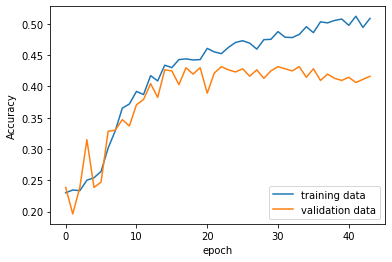

Accuracy of training set 0.530988
Accuracy of validation set 0.416244
Epoch 1/200
56/56 [==============================] - 1s 14ms/step - loss: 1.6520 - accuracy: 0.2278 - val_loss: 1.6121 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 2/200
56/56 [==============================] - 1s 12ms/step - loss: 1.6024 - accuracy: 0.2300 - val_loss: 1.5984 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 3/200
56/56 [==============================] - 1s 12ms/step - loss: 1.6000 - accuracy: 0.2429 - val_loss: 1.6071 - val_accuracy: 0.1760
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 4/200
56/56 [==============================] - 1s 12ms/step - loss: 1.5971 - accuracy: 0.2261 - val_loss: 1.5942 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 5/200
56/56 [==============================] - 1s 12ms/step - loss: 1.6015 - accuracy: 0.2306 - val_loss: 1.6052 - val_accuracy: 0.1760
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 6/200
56/56 [==============================] - 1s 12ms/step - loss: 1.5979 - accuracy: 0.2367 - val_loss: 1.6011 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 7/200
56/56 [==============================] - 1s 12ms/step - loss: 1.5936 - accuracy: 0.2390 - val_loss: 1.5927 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 8/200
56/56 [==============================] - 1s 14ms/step - loss: 1.5942 - accuracy: 0.2451 - val_loss: 1.5883 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 9/200
56/56 [==============================] - 1s 12ms/step - loss: 1.5863 - accuracy: 0.2725 - val_loss: 1.5846 - val_accuracy: 0.3113
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 10/200
56/56 [==============================] - 1s 11ms/step - loss: 1.5741 - accuracy: 0.2842 - val_loss: 1.5732 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 11/200
56/56 [==============================] - 1s 12ms/step - loss: 1.5544 - accuracy: 0.3121 - val_loss: 1.5263 - val_accuracy: 0.3266
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 12/200
56/56 [==============================] - 1s 12ms/step - loss: 1.5237 - accuracy: 0.3333 - val_loss: 1.4994 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 13/200
56/56 [==============================] - 1s 14ms/step - loss: 1.4760 - accuracy: 0.3713 - val_loss: 1.4751 - val_accuracy: 0.3452
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 14/200
56/56 [==============================] - 2s 29ms/step - loss: 1.4725 - accuracy: 0.3668 - val_loss: 1.4856 - val_accuracy: 0.3367
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 15/200
56/56 [==============================] - 2s 27ms/step - loss: 1.4449 - accuracy: 0.3802 - val_loss: 1.4698 - val_accuracy: 0.3469
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 16/200
56/56 [==============================] - 1s 24ms/step - loss: 1.4364 - accuracy: 0.3724 - val_loss: 1.4436 - val_accuracy: 0.3587
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 17/200
56/56 [==============================] - 1s 20ms/step - loss: 1.4262 - accuracy: 0.3864 - val_loss: 1.4326 - val_accuracy: 0.3672
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 18/200
56/56 [==============================] - 1s 20ms/step - loss: 1.3937 - accuracy: 0.3936 - val_loss: 1.4221 - val_accuracy: 0.3519
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 19/200
56/56 [==============================] - 1s 14ms/step - loss: 1.3975 - accuracy: 0.3942 - val_loss: 1.4809 - val_accuracy: 0.3147
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 20/200
56/56 [==============================] - 1s 14ms/step - loss: 1.3844 - accuracy: 0.4026 - val_loss: 1.4023 - val_accuracy: 0.3756
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 21/200
56/56 [==============================] - 1s 15ms/step - loss: 1.3456 - accuracy: 0.4204 - val_loss: 1.3760 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 22/200
56/56 [==============================] - 1s 16ms/step - loss: 1.3289 - accuracy: 0.4176 - val_loss: 1.3497 - val_accuracy: 0.3976
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 23/200
56/56 [==============================] - 1s 17ms/step - loss: 1.3256 - accuracy: 0.4283 - val_loss: 1.3293 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 24/200
56/56 [==============================] - 1s 17ms/step - loss: 1.3175 - accuracy: 0.4238 - val_loss: 1.3399 - val_accuracy: 0.3993
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 25/200
56/56 [==============================] - 1s 16ms/step - loss: 1.3139 - accuracy: 0.4154 - val_loss: 1.3215 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 26/200
56/56 [==============================] - 1s 16ms/step - loss: 1.2887 - accuracy: 0.4489 - val_loss: 1.3146 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 27/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2957 - accuracy: 0.4534 - val_loss: 1.3130 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 28/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2747 - accuracy: 0.4350 - val_loss: 1.3192 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 29/200
56/56 [==============================] - 1s 15ms/step - loss: 1.2793 - accuracy: 0.4422 - val_loss: 1.3071 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 30/200
56/56 [==============================] - 1s 16ms/step - loss: 1.2677 - accuracy: 0.4489 - val_loss: 1.3057 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 31/200
56/56 [==============================] - 1s 19ms/step - loss: 1.2503 - accuracy: 0.4606 - val_loss: 1.3029 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 32/200
56/56 [==============================] - 1s 16ms/step - loss: 1.2595 - accuracy: 0.4489 - val_loss: 1.2718 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 33/200
56/56 [==============================] - 1s 17ms/step - loss: 1.2495 - accuracy: 0.4422 - val_loss: 1.2663 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 34/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2330 - accuracy: 0.4640 - val_loss: 1.2685 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 35/200
56/56 [==============================] - 1s 13ms/step - loss: 1.2270 - accuracy: 0.4595 - val_loss: 1.2700 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 36/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2124 - accuracy: 0.4640 - val_loss: 1.2791 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 37/200
56/56 [==============================] - 1s 13ms/step - loss: 1.2212 - accuracy: 0.4740 - val_loss: 1.2689 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 38/200
56/56 [==============================] - 1s 15ms/step - loss: 1.2117 - accuracy: 0.4690 - val_loss: 1.2856 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 39/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2175 - accuracy: 0.4612 - val_loss: 1.2795 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 40/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2237 - accuracy: 0.4724 - val_loss: 1.2749 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 41/200
56/56 [==============================] - 1s 14ms/step - loss: 1.2056 - accuracy: 0.4819 - val_loss: 1.2450 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 42/200
56/56 [==============================] - 1s 14ms/step - loss: 1.1821 - accuracy: 0.4819 - val_loss: 1.2553 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 43/200
56/56 [==============================] - 1s 18ms/step - loss: 1.2026 - accuracy: 0.4791 - val_loss: 1.2489 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 44/200
56/56 [==============================] - 1s 20ms/step - loss: 1.1693 - accuracy: 0.4908 - val_loss: 1.2632 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 45/200
56/56 [==============================] - 1s 19ms/step - loss: 1.1902 - accuracy: 0.4645 - val_loss: 1.2454 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 46/200
56/56 [==============================] - 1s 19ms/step - loss: 1.1777 - accuracy: 0.4824 - val_loss: 1.3078 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 47/200
56/56 [==============================] - 1s 15ms/step - loss: 1.1798 - accuracy: 0.4752 - val_loss: 1.2722 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 48/200
56/56 [==============================] - 1s 15ms/step - loss: 1.1727 - accuracy: 0.4779 - val_loss: 1.2543 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 49/200
56/56 [==============================] - 1s 15ms/step - loss: 1.1526 - accuracy: 0.4908 - val_loss: 1.2960 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 50/200
56/56 [==============================] - 1s 17ms/step - loss: 1.1683 - accuracy: 0.4791 - val_loss: 1.2589 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 51/200
56/56 [==============================] - 1s 16ms/step - loss: 1.1559 - accuracy: 0.4908 - val_loss: 1.2581 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


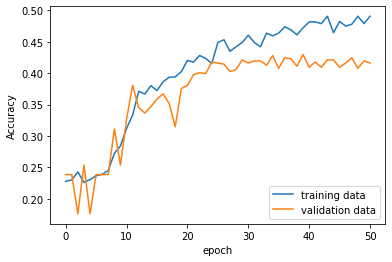

Accuracy of training set 0.515913
Accuracy of validation set 0.416244
Epoch 1/200
56/56 [==============================] - 1s 12ms/step - loss: 1.6297 - accuracy: 0.2384 - val_loss: 1.6075 - val_accuracy: 0.1963
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 2/200
56/56 [==============================] - 0s 8ms/step - loss: 1.6047 - accuracy: 0.2473 - val_loss: 1.6051 - val_accuracy: 0.1760
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 3/200
56/56 [==============================] - 0s 8ms/step - loss: 1.5980 - accuracy: 0.2295 - val_loss: 1.5970 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 4/200
56/56 [==============================] - 0s 8ms/step - loss: 1.5978 - accuracy: 0.2412 - val_loss: 1.5968 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 5/200
56/56 [==============================] - 1s 9ms/step - loss: 1.5946 - accuracy: 0.2384 - val_loss: 1.5986 - val_accuracy: 0.2910
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 6/200
56/56 [==============================] - 1s 9ms/step - loss: 1.5933 - accuracy: 0.2496 - val_loss: 1.5873 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 7/200
56/56 [==============================] - 1s 9ms/step - loss: 1.5894 - accuracy: 0.2652 - val_loss: 1.5760 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 8/200
56/56 [==============================] - 0s 9ms/step - loss: 1.5724 - accuracy: 0.2848 - val_loss: 1.5722 - val_accuracy: 0.2961
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 9/200
56/56 [==============================] - 0s 8ms/step - loss: 1.5515 - accuracy: 0.3076 - val_loss: 1.5580 - val_accuracy: 0.3232
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 10/200
56/56 [==============================] - 0s 8ms/step - loss: 1.5266 - accuracy: 0.3400 - val_loss: 1.5159 - val_accuracy: 0.3418
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 11/200
56/56 [==============================] - 0s 7ms/step - loss: 1.5140 - accuracy: 0.3534 - val_loss: 1.5138 - val_accuracy: 0.3316
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 12/200
56/56 [==============================] - 0s 8ms/step - loss: 1.4881 - accuracy: 0.3512 - val_loss: 1.5028 - val_accuracy: 0.3316
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 13/200
56/56 [==============================] - 1s 9ms/step - loss: 1.4806 - accuracy: 0.3696 - val_loss: 1.4948 - val_accuracy: 0.3435
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 14/200
56/56 [==============================] - 0s 7ms/step - loss: 1.4567 - accuracy: 0.3791 - val_loss: 1.4653 - val_accuracy: 0.3638
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 15/200
56/56 [==============================] - 0s 9ms/step - loss: 1.4491 - accuracy: 0.3819 - val_loss: 1.4522 - val_accuracy: 0.3689
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 16/200
56/56 [==============================] - 0s 8ms/step - loss: 1.4305 - accuracy: 0.3808 - val_loss: 1.4439 - val_accuracy: 0.3824
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 17/200
56/56 [==============================] - 0s 8ms/step - loss: 1.4155 - accuracy: 0.3881 - val_loss: 1.4261 - val_accuracy: 0.3790
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 18/200
56/56 [==============================] - 0s 8ms/step - loss: 1.4005 - accuracy: 0.3897 - val_loss: 1.4108 - val_accuracy: 0.3959
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 19/200
56/56 [==============================] - 0s 8ms/step - loss: 1.3819 - accuracy: 0.4020 - val_loss: 1.4004 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 20/200
56/56 [==============================] - 0s 8ms/step - loss: 1.3599 - accuracy: 0.4149 - val_loss: 1.3883 - val_accuracy: 0.3942
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 21/200
56/56 [==============================] - 1s 9ms/step - loss: 1.3496 - accuracy: 0.4199 - val_loss: 1.3828 - val_accuracy: 0.3773
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 22/200
56/56 [==============================] - 0s 8ms/step - loss: 1.3437 - accuracy: 0.4176 - val_loss: 1.3643 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 23/200
56/56 [==============================] - 0s 9ms/step - loss: 1.3330 - accuracy: 0.4160 - val_loss: 1.3481 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 24/200
56/56 [==============================] - 0s 8ms/step - loss: 1.3288 - accuracy: 0.4294 - val_loss: 1.3499 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 25/200
56/56 [==============================] - 0s 8ms/step - loss: 1.3138 - accuracy: 0.4344 - val_loss: 1.3383 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 26/200
56/56 [==============================] - 0s 7ms/step - loss: 1.3044 - accuracy: 0.4444 - val_loss: 1.3231 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 27/200
56/56 [==============================] - 0s 8ms/step - loss: 1.3121 - accuracy: 0.4327 - val_loss: 1.3391 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 28/200
56/56 [==============================] - 0s 9ms/step - loss: 1.2880 - accuracy: 0.4333 - val_loss: 1.3177 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 29/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2859 - accuracy: 0.4405 - val_loss: 1.3374 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 30/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2774 - accuracy: 0.4545 - val_loss: 1.3138 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 31/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2712 - accuracy: 0.4545 - val_loss: 1.3022 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 32/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2467 - accuracy: 0.4511 - val_loss: 1.3026 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 33/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2490 - accuracy: 0.4534 - val_loss: 1.2904 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 34/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2493 - accuracy: 0.4718 - val_loss: 1.2987 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 35/200
56/56 [==============================] - 1s 10ms/step - loss: 1.2542 - accuracy: 0.4489 - val_loss: 1.3108 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 36/200
56/56 [==============================] - 1s 10ms/step - loss: 1.2456 - accuracy: 0.4545 - val_loss: 1.2954 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 37/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2440 - accuracy: 0.4590 - val_loss: 1.2837 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 38/200
56/56 [==============================] - 0s 9ms/step - loss: 1.2467 - accuracy: 0.4484 - val_loss: 1.3296 - val_accuracy: 0.3892
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 39/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2537 - accuracy: 0.4567 - val_loss: 1.2960 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 40/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2238 - accuracy: 0.4807 - val_loss: 1.2878 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 41/200
56/56 [==============================] - 0s 7ms/step - loss: 1.2182 - accuracy: 0.4685 - val_loss: 1.2911 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 42/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2228 - accuracy: 0.4701 - val_loss: 1.2954 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 43/200
56/56 [==============================] - 1s 9ms/step - loss: 1.2121 - accuracy: 0.4640 - val_loss: 1.2826 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 44/200
56/56 [==============================] - 0s 9ms/step - loss: 1.2050 - accuracy: 0.4791 - val_loss: 1.2888 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 45/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2122 - accuracy: 0.4707 - val_loss: 1.2707 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 46/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2113 - accuracy: 0.4696 - val_loss: 1.2884 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 47/200
56/56 [==============================] - 0s 8ms/step - loss: 1.2101 - accuracy: 0.4673 - val_loss: 1.2974 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 48/200
56/56 [==============================] - 0s 8ms/step - loss: 1.1902 - accuracy: 0.4774 - val_loss: 1.2918 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 49/200
56/56 [==============================] - 0s 8ms/step - loss: 1.1990 - accuracy: 0.4768 - val_loss: 1.2822 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 50/200
56/56 [==============================] - 0s 7ms/step - loss: 1.1731 - accuracy: 0.4925 - val_loss: 1.2948 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 51/200
56/56 [==============================] - 0s 8ms/step - loss: 1.1896 - accuracy: 0.4768 - val_loss: 1.2891 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 52/200
56/56 [==============================] - 0s 8ms/step - loss: 1.1789 - accuracy: 0.4852 - val_loss: 1.2777 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 53/200
56/56 [==============================] - 0s 7ms/step - loss: 1.1646 - accuracy: 0.4969 - val_loss: 1.2852 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 54/200
56/56 [==============================] - 0s 7ms/step - loss: 1.1615 - accuracy: 0.4969 - val_loss: 1.2602 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 55/200
56/56 [==============================] - 0s 6ms/step - loss: 1.1707 - accuracy: 0.4874 - val_loss: 1.2705 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 56/200
56/56 [==============================] - 0s 6ms/step - loss: 1.1630 - accuracy: 0.4874 - val_loss: 1.2623 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 57/200
56/56 [==============================] - 0s 6ms/step - loss: 1.1468 - accuracy: 0.4958 - val_loss: 1.2738 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 58/200
56/56 [==============================] - 0s 6ms/step - loss: 1.1567 - accuracy: 0.4953 - val_loss: 1.2936 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 59/200
56/56 [==============================] - 0s 6ms/step - loss: 1.1354 - accuracy: 0.4969 - val_loss: 1.2869 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 60/200
56/56 [==============================] - 0s 7ms/step - loss: 1.1513 - accuracy: 0.4947 - val_loss: 1.2706 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 61/200
56/56 [==============================] - 1s 10ms/step - loss: 1.1447 - accuracy: 0.4986 - val_loss: 1.3034 - val_accuracy: 0.3959
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 62/200
56/56 [==============================] - 0s 8ms/step - loss: 1.1367 - accuracy: 0.5025 - val_loss: 1.2916 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 63/200
56/56 [==============================] - 0s 7ms/step - loss: 1.1293 - accuracy: 0.5064 - val_loss: 1.2799 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 64/200
56/56 [==============================] - 0s 8ms/step - loss: 1.1409 - accuracy: 0.4980 - val_loss: 1.2920 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


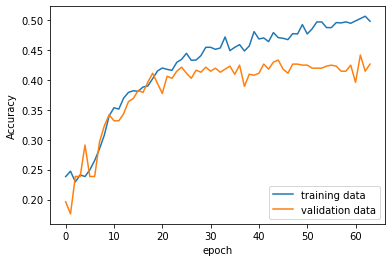

Accuracy of training set 0.521496
Accuracy of validation set 0.426396
Epoch 1/200
56/56 [==============================] - 1s 10ms/step - loss: 1.6871 - accuracy: 0.1993 - val_loss: 1.6025 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 2/200
56/56 [==============================] - 0s 5ms/step - loss: 1.6039 - accuracy: 0.2205 - val_loss: 1.6173 - val_accuracy: 0.2267
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 3/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5995 - accuracy: 0.2485 - val_loss: 1.6099 - val_accuracy: 0.2555
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 4/200
56/56 [==============================] - 0s 5ms/step - loss: 1.6014 - accuracy: 0.2267 - val_loss: 1.6034 - val_accuracy: 0.2487
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 5/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5974 - accuracy: 0.2289 - val_loss: 1.6086 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 6/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5944 - accuracy: 0.2434 - val_loss: 1.5929 - val_accuracy: 0.2420
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 7/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5956 - accuracy: 0.2518 - val_loss: 1.5944 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 8/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5906 - accuracy: 0.2535 - val_loss: 1.5944 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 9/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5912 - accuracy: 0.2468 - val_loss: 1.5949 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 10/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5843 - accuracy: 0.2585 - val_loss: 1.5971 - val_accuracy: 0.2623
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 11/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5754 - accuracy: 0.2747 - val_loss: 1.5829 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 12/200
56/56 [==============================] - 0s 4ms/step - loss: 1.5585 - accuracy: 0.3250 - val_loss: 1.5717 - val_accuracy: 0.2166
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 13/200
56/56 [==============================] - 0s 5ms/step - loss: 1.5325 - accuracy: 0.3210 - val_loss: 1.5183 - val_accuracy: 0.3519
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 14/200
56/56 [==============================] - 0s 4ms/step - loss: 1.4924 - accuracy: 0.3339 - val_loss: 1.4800 - val_accuracy: 0.3587
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 15/200
56/56 [==============================] - 0s 4ms/step - loss: 1.4681 - accuracy: 0.3713 - val_loss: 1.4543 - val_accuracy: 0.3739
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 16/200
56/56 [==============================] - 0s 4ms/step - loss: 1.4430 - accuracy: 0.3841 - val_loss: 1.4463 - val_accuracy: 0.3604
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 17/200
56/56 [==============================] - 0s 4ms/step - loss: 1.4498 - accuracy: 0.3590 - val_loss: 1.4533 - val_accuracy: 0.3706
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 18/200
56/56 [==============================] - 0s 4ms/step - loss: 1.4197 - accuracy: 0.3853 - val_loss: 1.4405 - val_accuracy: 0.3689
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 19/200
56/56 [==============================] - 0s 4ms/step - loss: 1.4102 - accuracy: 0.4048 - val_loss: 1.4429 - val_accuracy: 0.3739
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 20/200
56/56 [==============================] - 0s 5ms/step - loss: 1.3808 - accuracy: 0.4249 - val_loss: 1.4106 - val_accuracy: 0.3824
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 21/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3950 - accuracy: 0.4076 - val_loss: 1.4359 - val_accuracy: 0.3486
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 22/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3757 - accuracy: 0.4104 - val_loss: 1.3991 - val_accuracy: 0.3942
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 23/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3678 - accuracy: 0.4065 - val_loss: 1.3946 - val_accuracy: 0.3909
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 24/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3843 - accuracy: 0.4082 - val_loss: 1.3763 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 25/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3313 - accuracy: 0.4422 - val_loss: 1.3723 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 26/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3343 - accuracy: 0.4188 - val_loss: 1.3509 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 27/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3383 - accuracy: 0.4137 - val_loss: 1.3674 - val_accuracy: 0.3993
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 28/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3227 - accuracy: 0.4154 - val_loss: 1.3584 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 29/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3171 - accuracy: 0.4132 - val_loss: 1.3361 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 30/200
56/56 [==============================] - 0s 5ms/step - loss: 1.3075 - accuracy: 0.4422 - val_loss: 1.3465 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 31/200
56/56 [==============================] - 0s 5ms/step - loss: 1.3114 - accuracy: 0.4316 - val_loss: 1.3536 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 32/200
56/56 [==============================] - 0s 5ms/step - loss: 1.3201 - accuracy: 0.4344 - val_loss: 1.3390 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 33/200
56/56 [==============================] - 0s 4ms/step - loss: 1.3032 - accuracy: 0.4243 - val_loss: 1.3427 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 34/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2817 - accuracy: 0.4411 - val_loss: 1.3223 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 35/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2847 - accuracy: 0.4517 - val_loss: 1.3259 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 36/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2855 - accuracy: 0.4444 - val_loss: 1.3384 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 37/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2762 - accuracy: 0.4422 - val_loss: 1.3187 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 38/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2938 - accuracy: 0.4394 - val_loss: 1.3226 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 39/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2702 - accuracy: 0.4484 - val_loss: 1.3154 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 40/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2633 - accuracy: 0.4417 - val_loss: 1.3225 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 41/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2750 - accuracy: 0.4495 - val_loss: 1.3095 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 42/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2693 - accuracy: 0.4383 - val_loss: 1.2922 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 43/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2571 - accuracy: 0.4528 - val_loss: 1.2901 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 44/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2665 - accuracy: 0.4456 - val_loss: 1.2956 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 45/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2500 - accuracy: 0.4500 - val_loss: 1.2885 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 46/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2593 - accuracy: 0.4506 - val_loss: 1.2983 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 47/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2551 - accuracy: 0.4562 - val_loss: 1.2914 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 48/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2446 - accuracy: 0.4467 - val_loss: 1.2889 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 49/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2323 - accuracy: 0.4634 - val_loss: 1.2863 - val_accuracy: 0.4433
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 50/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2426 - accuracy: 0.4517 - val_loss: 1.2820 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 51/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2429 - accuracy: 0.4545 - val_loss: 1.2867 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 52/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2394 - accuracy: 0.4662 - val_loss: 1.3160 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 53/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2465 - accuracy: 0.4556 - val_loss: 1.2895 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 54/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2298 - accuracy: 0.4629 - val_loss: 1.2777 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 55/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2306 - accuracy: 0.4573 - val_loss: 1.2696 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 56/200
56/56 [==============================] - 0s 5ms/step - loss: 1.2366 - accuracy: 0.4456 - val_loss: 1.2896 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 57/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2288 - accuracy: 0.4629 - val_loss: 1.2731 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 58/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2198 - accuracy: 0.4629 - val_loss: 1.2744 - val_accuracy: 0.4518
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 59/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2173 - accuracy: 0.4657 - val_loss: 1.2830 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 60/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2153 - accuracy: 0.4539 - val_loss: 1.2827 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 61/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2271 - accuracy: 0.4556 - val_loss: 1.2601 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 62/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2346 - accuracy: 0.4450 - val_loss: 1.2879 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 63/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2120 - accuracy: 0.4517 - val_loss: 1.2583 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 64/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2134 - accuracy: 0.4618 - val_loss: 1.2763 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 65/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2242 - accuracy: 0.4668 - val_loss: 1.2775 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 66/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2146 - accuracy: 0.4662 - val_loss: 1.2885 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 67/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2114 - accuracy: 0.4623 - val_loss: 1.2647 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 68/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2055 - accuracy: 0.4696 - val_loss: 1.2603 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 69/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2174 - accuracy: 0.4618 - val_loss: 1.2628 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 70/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2156 - accuracy: 0.4506 - val_loss: 1.2469 - val_accuracy: 0.4670
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 71/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1976 - accuracy: 0.4763 - val_loss: 1.2553 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 72/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2039 - accuracy: 0.4735 - val_loss: 1.2557 - val_accuracy: 0.4501
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 73/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2155 - accuracy: 0.4685 - val_loss: 1.2725 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 74/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1917 - accuracy: 0.4740 - val_loss: 1.2627 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 75/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2198 - accuracy: 0.4685 - val_loss: 1.2477 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 76/200
56/56 [==============================] - 0s 4ms/step - loss: 1.2035 - accuracy: 0.4752 - val_loss: 1.2446 - val_accuracy: 0.4467
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 77/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1901 - accuracy: 0.4774 - val_loss: 1.2613 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 78/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1933 - accuracy: 0.4902 - val_loss: 1.2484 - val_accuracy: 0.4450
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 79/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1978 - accuracy: 0.4673 - val_loss: 1.2733 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 80/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1866 - accuracy: 0.4880 - val_loss: 1.2531 - val_accuracy: 0.4450
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 81/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1916 - accuracy: 0.4712 - val_loss: 1.2469 - val_accuracy: 0.4518
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 82/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1799 - accuracy: 0.4779 - val_loss: 1.2478 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 83/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1774 - accuracy: 0.4813 - val_loss: 1.2657 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 84/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1812 - accuracy: 0.4846 - val_loss: 1.2505 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 85/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1646 - accuracy: 0.4897 - val_loss: 1.2383 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 86/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1678 - accuracy: 0.4897 - val_loss: 1.2546 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 87/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1847 - accuracy: 0.4824 - val_loss: 1.2539 - val_accuracy: 0.4501
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 88/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1668 - accuracy: 0.4813 - val_loss: 1.2687 - val_accuracy: 0.4518
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 89/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1752 - accuracy: 0.4774 - val_loss: 1.2570 - val_accuracy: 0.4636
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 90/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1708 - accuracy: 0.4841 - val_loss: 1.2400 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 91/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1769 - accuracy: 0.4740 - val_loss: 1.2705 - val_accuracy: 0.3841
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 92/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1831 - accuracy: 0.4813 - val_loss: 1.2315 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 93/200
56/56 [==============================] - 0s 3ms/step - loss: 1.1721 - accuracy: 0.4891 - val_loss: 1.2444 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 94/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1688 - accuracy: 0.4897 - val_loss: 1.2489 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 95/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1636 - accuracy: 0.4785 - val_loss: 1.2456 - val_accuracy: 0.4450
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 96/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1594 - accuracy: 0.4752 - val_loss: 1.2348 - val_accuracy: 0.4518
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 97/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1627 - accuracy: 0.4908 - val_loss: 1.2586 - val_accuracy: 0.4450
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 98/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1580 - accuracy: 0.4796 - val_loss: 1.2570 - val_accuracy: 0.4433
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 99/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1500 - accuracy: 0.4969 - val_loss: 1.2639 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 100/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1576 - accuracy: 0.4992 - val_loss: 1.2478 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 101/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1683 - accuracy: 0.4785 - val_loss: 1.2436 - val_accuracy: 0.4585
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


Epoch 102/200
56/56 [==============================] - 0s 4ms/step - loss: 1.1463 - accuracy: 0.4858 - val_loss: 1.2532 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


INFO:tensorflow:Assets written to: model5_cnn1D_changefilters.hd5\assets


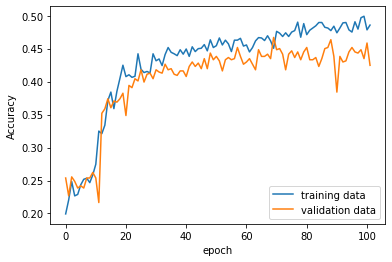

Accuracy of training set 0.509771
Accuracy of validation set 0.424704


In [162]:
MODEL_NAME5 = 'model5_cnn1D_changefilters.hd5'

neurons_lst = [[512,256,128],[256,128,64],[128,64,32],[64,32,16],[32,16,8]]

for triple in neurons_lst:

    #build model
    model5 = models.Sequential()
    model5.add(layers.Conv1D(filters=triple[0], kernel_size=4, activation='relu', input_shape=(10,4)))
    model5.add(layers.Conv1D(filters=triple[1], kernel_size=3, activation='relu'))
    model5.add(layers.Dropout(0.5))
    model5.add(layers.Conv1D(filters=triple[2], kernel_size=2, activation='relu'))
    model5.add(layers.MaxPooling1D(pool_size=2))
    model5.add(layers.Flatten())
    model5.add(layers.Dense(100, activation='relu'))
    model5.add(layers.Dense(6, activation='softmax'))
    
    adam = keras.optimizers.Adam(learning_rate=0.001)
    model5.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    savemodel = ModelCheckpoint(MODEL_NAME5)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)
    
    learning_model5 = model5.fit(Xtrain, ytrain, epochs=200, batch_size=32, validation_data=(Xval,yval), callbacks=[savemodel, stopmodel])
    
    #plot graphs
    plt.plot(learning_model5.history['accuracy'])
    plt.plot(learning_model5.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.show()
    
    #print accuracy 
    #training set 
    trainPredict = model5.predict(Xtrain)
    trainPredict = mapResultsToClass(trainPredict)
    trainAccuracy = accuracy_score(ytrain, trainPredict)
    print("Accuracy of training set %f" % trainAccuracy)

    #validation set 
    valPredict = model5.predict(Xval)
    valPredict = mapResultsToClass(valPredict)
    valAccuracy = accuracy_score(yval, valPredict)
    print("Accuracy of validation set %f" % valAccuracy)

[512,256,128] gives the best performance. I will explore the effect of adding more layers. 

In [20]:
def buildModelAndEvaluate(inputModel, modelName='model6_cnn1D_changelayers.hd5'):
    
    MODEL_NAME6 = modelName
    
    adam = keras.optimizers.Adam(learning_rate=0.001)
    inputModel.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    savemodel = ModelCheckpoint(MODEL_NAME6)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)
    
    learning_model6 = inputModel.fit(Xtrain, ytrain, epochs=200, batch_size=32, validation_data=(Xval,yval), callbacks=[savemodel, stopmodel])
    
    #plot graphs
    plt.plot(learning_model6.history['accuracy'])
    plt.plot(learning_model6.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.show()
    
    #print accuracy 
    #training set 
    trainPredict = inputModel.predict(Xtrain)
    trainPredict = mapResultsToClass(trainPredict)
    trainAccuracy = accuracy_score(ytrain, trainPredict)
    print("Accuracy of training set %f" % trainAccuracy)

    #validation set 
    valPredict = inputModel.predict(Xval)
    valPredict = mapResultsToClass(valPredict)
    valAccuracy = accuracy_score(yval, valPredict)
    print("Accuracy of validation set %f" % valAccuracy)

Epoch 1/200
56/56 [==============================] - 4s 58ms/step - loss: 1.6216 - accuracy: 0.2261 - val_loss: 1.6152 - val_accuracy: 0.2961
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 2/200
56/56 [==============================] - 3s 54ms/step - loss: 1.5921 - accuracy: 0.2356 - val_loss: 1.5791 - val_accuracy: 0.2555
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 3/200
56/56 [==============================] - 3s 55ms/step - loss: 1.5005 - accuracy: 0.3289 - val_loss: 1.4464 - val_accuracy: 0.3993
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 4/200
56/56 [==============================] - 3s 56ms/step - loss: 1.3626 - accuracy: 0.3964 - val_loss: 1.3662 - val_accuracy: 0.3858
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 5/200
56/56 [==============================] - 3s 55ms/step - loss: 1.3040 - accuracy: 0.4093 - val_loss: 1.3606 - val_accuracy: 0.3959
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 6/200
56/56 [==============================] - 3s 54ms/step - loss: 1.2762 - accuracy: 0.4400 - val_loss: 1.3094 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 7/200
56/56 [==============================] - 3s 53ms/step - loss: 1.2622 - accuracy: 0.4461 - val_loss: 1.3194 - val_accuracy: 0.3976
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 8/200
56/56 [==============================] - 3s 61ms/step - loss: 1.2546 - accuracy: 0.4338 - val_loss: 1.2663 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 9/200
56/56 [==============================] - 3s 63ms/step - loss: 1.2355 - accuracy: 0.4517 - val_loss: 1.3210 - val_accuracy: 0.3942
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 10/200
56/56 [==============================] - 3s 63ms/step - loss: 1.2318 - accuracy: 0.4461 - val_loss: 1.2842 - val_accuracy: 0.3909
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 11/200
56/56 [==============================] - 4s 66ms/step - loss: 1.2081 - accuracy: 0.4545 - val_loss: 1.2508 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 12/200
56/56 [==============================] - 3s 61ms/step - loss: 1.1912 - accuracy: 0.4718 - val_loss: 1.2614 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 13/200
56/56 [==============================] - 3s 58ms/step - loss: 1.1903 - accuracy: 0.4757 - val_loss: 1.3129 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 14/200
56/56 [==============================] - 4s 63ms/step - loss: 1.1878 - accuracy: 0.4634 - val_loss: 1.2861 - val_accuracy: 0.3841
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 15/200
56/56 [==============================] - 3s 59ms/step - loss: 1.1717 - accuracy: 0.4746 - val_loss: 1.2439 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 16/200
56/56 [==============================] - 3s 56ms/step - loss: 1.1545 - accuracy: 0.4718 - val_loss: 1.2169 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 17/200
56/56 [==============================] - 3s 61ms/step - loss: 1.1372 - accuracy: 0.4701 - val_loss: 1.2417 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 18/200
56/56 [==============================] - 3s 62ms/step - loss: 1.1365 - accuracy: 0.4891 - val_loss: 1.2075 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 19/200
56/56 [==============================] - 3s 56ms/step - loss: 1.1201 - accuracy: 0.5014 - val_loss: 1.2748 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 20/200
56/56 [==============================] - 3s 55ms/step - loss: 1.1071 - accuracy: 0.4975 - val_loss: 1.2232 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 21/200
56/56 [==============================] - 4s 63ms/step - loss: 1.1027 - accuracy: 0.4975 - val_loss: 1.2207 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 22/200
56/56 [==============================] - 3s 58ms/step - loss: 1.0895 - accuracy: 0.4997 - val_loss: 1.2157 - val_accuracy: 0.4399
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 23/200
56/56 [==============================] - 3s 58ms/step - loss: 1.0901 - accuracy: 0.5120 - val_loss: 1.2426 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 24/200
56/56 [==============================] - 3s 58ms/step - loss: 1.0819 - accuracy: 0.5159 - val_loss: 1.2313 - val_accuracy: 0.4399
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 25/200
56/56 [==============================] - 3s 62ms/step - loss: 1.0670 - accuracy: 0.5187 - val_loss: 1.2673 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 26/200
56/56 [==============================] - 3s 57ms/step - loss: 1.0572 - accuracy: 0.5343 - val_loss: 1.2799 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 27/200
56/56 [==============================] - 3s 59ms/step - loss: 1.0438 - accuracy: 0.5226 - val_loss: 1.2443 - val_accuracy: 0.4585
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 28/200
56/56 [==============================] - 3s 62ms/step - loss: 1.0281 - accuracy: 0.5505 - val_loss: 1.2619 - val_accuracy: 0.4382
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


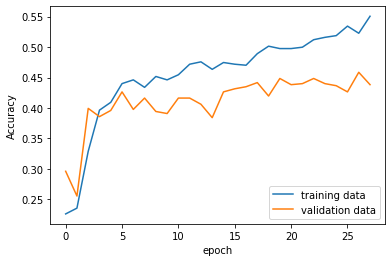

Accuracy of training set 0.556672
Accuracy of validation set 0.438240


In [169]:
#3 layers
model6 = models.Sequential()
model6.add(layers.Conv1D(filters=512, kernel_size=4, activation='relu', padding='same', input_shape=(10,4)))
model6.add(layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model6.add(layers.Dropout(0.5))
model6.add(layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model6.add(layers.MaxPooling1D(pool_size=2))
model6.add(layers.Flatten())
model6.add(layers.Dense(100, activation='relu'))
model6.add(layers.Dense(6, activation='softmax'))
buildModelAndEvaluate(model6)

Epoch 1/200
56/56 [==============================] - 15s 256ms/step - loss: 1.6397 - accuracy: 0.2239 - val_loss: 1.6045 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 2/200
56/56 [==============================] - 14s 257ms/step - loss: 1.6033 - accuracy: 0.2351 - val_loss: 1.5745 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 3/200
56/56 [==============================] - 14s 257ms/step - loss: 1.5767 - accuracy: 0.2624 - val_loss: 1.5206 - val_accuracy: 0.2690
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 4/200
56/56 [==============================] - 15s 261ms/step - loss: 1.4953 - accuracy: 0.3143 - val_loss: 1.4611 - val_accuracy: 0.2724
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 5/200
56/56 [==============================] - 15s 261ms/step - loss: 1.4004 - accuracy: 0.3540 - val_loss: 1.3290 - val_accuracy: 0.3942
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 6/200
56/56 [==============================] - 16s 287ms/step - loss: 1.3133 - accuracy: 0.4109 - val_loss: 1.3099 - val_accuracy: 0.3909
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 7/200
56/56 [==============================] - 34s 610ms/step - loss: 1.3003 - accuracy: 0.4204 - val_loss: 1.3938 - val_accuracy: 0.3164
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 8/200
56/56 [==============================] - 33s 600ms/step - loss: 1.2715 - accuracy: 0.4227 - val_loss: 1.3025 - val_accuracy: 0.3706
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 9/200
56/56 [==============================] - 34s 618ms/step - loss: 1.2811 - accuracy: 0.4137 - val_loss: 1.3012 - val_accuracy: 0.3993
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 10/200
56/56 [==============================] - 33s 586ms/step - loss: 1.2609 - accuracy: 0.4400 - val_loss: 1.2444 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 11/200
56/56 [==============================] - 34s 611ms/step - loss: 1.2326 - accuracy: 0.4461 - val_loss: 1.2430 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 12/200
56/56 [==============================] - 31s 552ms/step - loss: 1.2266 - accuracy: 0.4439 - val_loss: 1.2612 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 13/200
56/56 [==============================] - 21s 382ms/step - loss: 1.2238 - accuracy: 0.4534 - val_loss: 1.2175 - val_accuracy: 0.4569
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 14/200
56/56 [==============================] - 18s 322ms/step - loss: 1.1906 - accuracy: 0.4662 - val_loss: 1.2711 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 15/200
56/56 [==============================] - 25s 443ms/step - loss: 1.1947 - accuracy: 0.4629 - val_loss: 1.2517 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 16/200
56/56 [==============================] - 33s 594ms/step - loss: 1.1751 - accuracy: 0.4701 - val_loss: 1.2524 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 17/200
56/56 [==============================] - 32s 576ms/step - loss: 1.1723 - accuracy: 0.4729 - val_loss: 1.2365 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 18/200
56/56 [==============================] - 34s 611ms/step - loss: 1.1688 - accuracy: 0.4902 - val_loss: 1.2355 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 19/200
56/56 [==============================] - 35s 626ms/step - loss: 1.1718 - accuracy: 0.4919 - val_loss: 1.2247 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 20/200
56/56 [==============================] - 33s 581ms/step - loss: 1.1781 - accuracy: 0.4729 - val_loss: 1.2524 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 21/200
56/56 [==============================] - 34s 606ms/step - loss: 1.1422 - accuracy: 0.4980 - val_loss: 1.2493 - val_accuracy: 0.3959
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 22/200
56/56 [==============================] - 30s 538ms/step - loss: 1.1232 - accuracy: 0.4980 - val_loss: 1.2293 - val_accuracy: 0.4365
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 23/200
56/56 [==============================] - 31s 563ms/step - loss: 1.1342 - accuracy: 0.4964 - val_loss: 1.2649 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


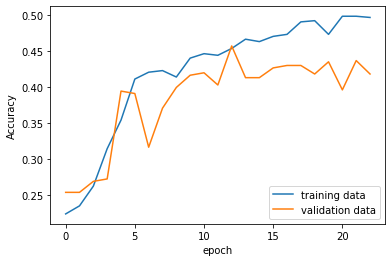

Accuracy of training set 0.492462
Accuracy of validation set 0.417936


In [170]:
#4 layers
model7 = models.Sequential()
model7.add(layers.Conv1D(filters=1024, kernel_size=4, activation='relu', padding='same', input_shape=(10,4)))
model7.add(layers.Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Conv1D(filters=256, kernel_size=2, padding='same', activation='relu'))
model7.add(layers.MaxPooling1D(pool_size=2))
model7.add(layers.Conv1D(filters=128, kernel_size=1, padding='same', activation='relu'))
model7.add(layers.Dropout(0.5))
model7.add(layers.Flatten())
model7.add(layers.Dense(100, activation='relu'))
model7.add(layers.Dense(6, activation='softmax'))
buildModelAndEvaluate(model7)

Epoch 1/200
56/56 [==============================] - 6s 96ms/step - loss: 1.6171 - accuracy: 0.2451 - val_loss: 1.5921 - val_accuracy: 0.1946
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 2/200
56/56 [==============================] - 7s 133ms/step - loss: 1.5825 - accuracy: 0.2769 - val_loss: 1.5672 - val_accuracy: 0.2741
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 3/200
56/56 [==============================] - 6s 103ms/step - loss: 1.5109 - accuracy: 0.3384 - val_loss: 1.4304 - val_accuracy: 0.3486
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 4/200
56/56 [==============================] - 5s 88ms/step - loss: 1.4085 - accuracy: 0.3724 - val_loss: 1.3558 - val_accuracy: 0.3892
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 5/200
56/56 [==============================] - 4s 80ms/step - loss: 1.3366 - accuracy: 0.4176 - val_loss: 1.3188 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 6/200
56/56 [==============================] - 5s 82ms/step - loss: 1.2955 - accuracy: 0.4372 - val_loss: 1.2999 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 7/200
56/56 [==============================] - 7s 126ms/step - loss: 1.2835 - accuracy: 0.4260 - val_loss: 1.3063 - val_accuracy: 0.3892
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 8/200
56/56 [==============================] - 6s 100ms/step - loss: 1.2620 - accuracy: 0.4333 - val_loss: 1.2904 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 9/200
56/56 [==============================] - 7s 120ms/step - loss: 1.2467 - accuracy: 0.4433 - val_loss: 1.2783 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 10/200
56/56 [==============================] - 7s 129ms/step - loss: 1.2418 - accuracy: 0.4389 - val_loss: 1.2764 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 11/200
56/56 [==============================] - 5s 86ms/step - loss: 1.2389 - accuracy: 0.4489 - val_loss: 1.2725 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 12/200
56/56 [==============================] - 7s 119ms/step - loss: 1.2145 - accuracy: 0.4668 - val_loss: 1.2530 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 13/200
56/56 [==============================] - 7s 120ms/step - loss: 1.2231 - accuracy: 0.4511 - val_loss: 1.2701 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 14/200
56/56 [==============================] - 7s 122ms/step - loss: 1.2157 - accuracy: 0.4662 - val_loss: 1.2454 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 15/200
56/56 [==============================] - 5s 82ms/step - loss: 1.1868 - accuracy: 0.4785 - val_loss: 1.2527 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 16/200
56/56 [==============================] - 6s 105ms/step - loss: 1.1887 - accuracy: 0.4629 - val_loss: 1.2787 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 17/200
56/56 [==============================] - 5s 82ms/step - loss: 1.1896 - accuracy: 0.4685 - val_loss: 1.2361 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 18/200
56/56 [==============================] - 5s 93ms/step - loss: 1.1950 - accuracy: 0.4673 - val_loss: 1.2424 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 19/200
56/56 [==============================] - 8s 137ms/step - loss: 1.1801 - accuracy: 0.4662 - val_loss: 1.2566 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 20/200
56/56 [==============================] - 5s 95ms/step - loss: 1.1604 - accuracy: 0.4835 - val_loss: 1.2251 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 21/200
56/56 [==============================] - 8s 142ms/step - loss: 1.1529 - accuracy: 0.4852 - val_loss: 1.2336 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 22/200
56/56 [==============================] - 6s 115ms/step - loss: 1.1545 - accuracy: 0.4835 - val_loss: 1.2279 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 23/200
56/56 [==============================] - 6s 109ms/step - loss: 1.1454 - accuracy: 0.4919 - val_loss: 1.2187 - val_accuracy: 0.4602
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 24/200
56/56 [==============================] - 7s 116ms/step - loss: 1.1444 - accuracy: 0.4785 - val_loss: 1.2268 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 25/200
56/56 [==============================] - 7s 121ms/step - loss: 1.1212 - accuracy: 0.5014 - val_loss: 1.2144 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 26/200
56/56 [==============================] - 7s 130ms/step - loss: 1.1184 - accuracy: 0.5221 - val_loss: 1.2363 - val_accuracy: 0.4416
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 27/200
56/56 [==============================] - 6s 112ms/step - loss: 1.1264 - accuracy: 0.4913 - val_loss: 1.2204 - val_accuracy: 0.4433
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 28/200
56/56 [==============================] - 7s 122ms/step - loss: 1.1045 - accuracy: 0.5148 - val_loss: 1.2520 - val_accuracy: 0.4129
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 29/200
56/56 [==============================] - 6s 99ms/step - loss: 1.1099 - accuracy: 0.5098 - val_loss: 1.2273 - val_accuracy: 0.4738
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 30/200
56/56 [==============================] - 6s 107ms/step - loss: 1.1016 - accuracy: 0.5221 - val_loss: 1.2453 - val_accuracy: 0.4281
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 31/200
56/56 [==============================] - 5s 96ms/step - loss: 1.0848 - accuracy: 0.5282 - val_loss: 1.2454 - val_accuracy: 0.4535
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 32/200
56/56 [==============================] - 6s 115ms/step - loss: 1.0792 - accuracy: 0.5243 - val_loss: 1.2265 - val_accuracy: 0.4755
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 33/200
56/56 [==============================] - 5s 90ms/step - loss: 1.0812 - accuracy: 0.5366 - val_loss: 1.2299 - val_accuracy: 0.4585
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 34/200
56/56 [==============================] - 6s 116ms/step - loss: 1.0736 - accuracy: 0.5276 - val_loss: 1.2580 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 35/200
56/56 [==============================] - 6s 101ms/step - loss: 1.0936 - accuracy: 0.5198 - val_loss: 1.2422 - val_accuracy: 0.4501
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


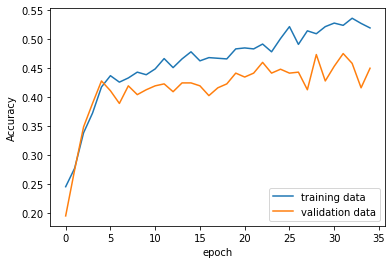

Accuracy of training set 0.569514
Accuracy of validation set 0.450085


In [171]:
#2 layers
model8 = models.Sequential()
model8.add(layers.Conv1D(filters=512, kernel_size=4, activation='relu', padding='same', input_shape=(10,4)))
model8.add(layers.Dropout(0.5))
model8.add(layers.Conv1D(filters=256, kernel_size=2, padding='same', activation='relu'))
model8.add(layers.MaxPooling1D(pool_size=2))
model8.add(layers.Flatten())
model8.add(layers.Dense(100, activation='relu'))
model8.add(layers.Dense(6, activation='softmax'))
buildModelAndEvaluate(model8)

Epoch 1/200
56/56 [==============================] - 37s 634ms/step - loss: 1.6445 - accuracy: 0.2418 - val_loss: 1.6026 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 2/200
56/56 [==============================] - 38s 679ms/step - loss: 1.6049 - accuracy: 0.2284 - val_loss: 1.5936 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 3/200
56/56 [==============================] - 39s 693ms/step - loss: 1.6044 - accuracy: 0.2334 - val_loss: 1.5897 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 4/200
56/56 [==============================] - 36s 648ms/step - loss: 1.5818 - accuracy: 0.2295 - val_loss: 1.5717 - val_accuracy: 0.1760
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 5/200
56/56 [==============================] - 40s 719ms/step - loss: 1.5315 - accuracy: 0.2429 - val_loss: 1.4815 - val_accuracy: 0.3113
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 6/200
56/56 [==============================] - 32s 581ms/step - loss: 1.4858 - accuracy: 0.2898 - val_loss: 1.4562 - val_accuracy: 0.3096
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 7/200
56/56 [==============================] - 38s 670ms/step - loss: 1.4490 - accuracy: 0.3076 - val_loss: 1.4227 - val_accuracy: 0.3638
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 8/200
56/56 [==============================] - 35s 633ms/step - loss: 1.4211 - accuracy: 0.3233 - val_loss: 1.4354 - val_accuracy: 0.3316
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 9/200
56/56 [==============================] - 31s 548ms/step - loss: 1.4034 - accuracy: 0.3300 - val_loss: 1.4010 - val_accuracy: 0.2995
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 10/200
56/56 [==============================] - 36s 638ms/step - loss: 1.3679 - accuracy: 0.3691 - val_loss: 1.3274 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 11/200
56/56 [==============================] - 38s 691ms/step - loss: 1.3617 - accuracy: 0.3853 - val_loss: 1.3939 - val_accuracy: 0.3790
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 12/200
56/56 [==============================] - 35s 631ms/step - loss: 1.3358 - accuracy: 0.3892 - val_loss: 1.3111 - val_accuracy: 0.3892
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 13/200
56/56 [==============================] - 40s 719ms/step - loss: 1.3020 - accuracy: 0.4121 - val_loss: 1.3015 - val_accuracy: 0.3976
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 14/200
56/56 [==============================] - 28s 498ms/step - loss: 1.2944 - accuracy: 0.4227 - val_loss: 1.2772 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 15/200
56/56 [==============================] - 30s 533ms/step - loss: 1.3173 - accuracy: 0.3892 - val_loss: 1.2965 - val_accuracy: 0.3926
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 16/200
56/56 [==============================] - 33s 590ms/step - loss: 1.2717 - accuracy: 0.4232 - val_loss: 1.2883 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 17/200
56/56 [==============================] - 36s 652ms/step - loss: 1.2841 - accuracy: 0.4216 - val_loss: 1.2854 - val_accuracy: 0.3993
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 18/200
56/56 [==============================] - 40s 719ms/step - loss: 1.2754 - accuracy: 0.4176 - val_loss: 1.3134 - val_accuracy: 0.3976
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 19/200
56/56 [==============================] - 42s 756ms/step - loss: 1.2806 - accuracy: 0.4327 - val_loss: 1.2747 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 20/200
56/56 [==============================] - 43s 775ms/step - loss: 1.2661 - accuracy: 0.4394 - val_loss: 1.3004 - val_accuracy: 0.3976
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 21/200
56/56 [==============================] - 40s 723ms/step - loss: 1.2736 - accuracy: 0.4188 - val_loss: 1.3145 - val_accuracy: 0.3723
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 22/200
56/56 [==============================] - 40s 711ms/step - loss: 1.2554 - accuracy: 0.4305 - val_loss: 1.2759 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 23/200
56/56 [==============================] - 42s 757ms/step - loss: 1.2612 - accuracy: 0.4305 - val_loss: 1.2694 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 24/200
56/56 [==============================] - 39s 695ms/step - loss: 1.2350 - accuracy: 0.4422 - val_loss: 1.2694 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 25/200
56/56 [==============================] - 39s 699ms/step - loss: 1.2515 - accuracy: 0.4377 - val_loss: 1.3085 - val_accuracy: 0.3841
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 26/200
56/56 [==============================] - 42s 748ms/step - loss: 1.2432 - accuracy: 0.4578 - val_loss: 1.2873 - val_accuracy: 0.3909
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 27/200
56/56 [==============================] - 44s 794ms/step - loss: 1.2542 - accuracy: 0.4461 - val_loss: 1.2746 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 28/200
56/56 [==============================] - 36s 649ms/step - loss: 1.2258 - accuracy: 0.4562 - val_loss: 1.2887 - val_accuracy: 0.4027
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 29/200
56/56 [==============================] - 38s 685ms/step - loss: 1.2363 - accuracy: 0.4366 - val_loss: 1.2750 - val_accuracy: 0.3892
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 30/200
56/56 [==============================] - 39s 696ms/step - loss: 1.2038 - accuracy: 0.4573 - val_loss: 1.2714 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 31/200
56/56 [==============================] - 38s 685ms/step - loss: 1.1954 - accuracy: 0.4578 - val_loss: 1.2591 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 32/200
56/56 [==============================] - 36s 634ms/step - loss: 1.2099 - accuracy: 0.4511 - val_loss: 1.2544 - val_accuracy: 0.4349
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 33/200
56/56 [==============================] - 41s 732ms/step - loss: 1.1847 - accuracy: 0.4645 - val_loss: 1.2637 - val_accuracy: 0.3976
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 34/200
56/56 [==============================] - 40s 721ms/step - loss: 1.1969 - accuracy: 0.4618 - val_loss: 1.2512 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 35/200
56/56 [==============================] - 42s 753ms/step - loss: 1.1787 - accuracy: 0.4634 - val_loss: 1.2451 - val_accuracy: 0.4315
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 36/200
56/56 [==============================] - 42s 762ms/step - loss: 1.1886 - accuracy: 0.4556 - val_loss: 1.2413 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 37/200
56/56 [==============================] - 43s 763ms/step - loss: 1.1713 - accuracy: 0.4729 - val_loss: 1.2373 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 38/200
56/56 [==============================] - 38s 691ms/step - loss: 1.1690 - accuracy: 0.4774 - val_loss: 1.2660 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 39/200
56/56 [==============================] - 37s 668ms/step - loss: 1.1596 - accuracy: 0.4891 - val_loss: 1.2589 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 40/200
56/56 [==============================] - 41s 722ms/step - loss: 1.1555 - accuracy: 0.4819 - val_loss: 1.2978 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 41/200
56/56 [==============================] - 39s 693ms/step - loss: 1.1496 - accuracy: 0.4807 - val_loss: 1.2897 - val_accuracy: 0.4162
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 42/200
56/56 [==============================] - 41s 739ms/step - loss: 1.1498 - accuracy: 0.4930 - val_loss: 1.2658 - val_accuracy: 0.4230
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 43/200
56/56 [==============================] - 35s 635ms/step - loss: 1.1498 - accuracy: 0.4701 - val_loss: 1.2464 - val_accuracy: 0.4213
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 44/200
56/56 [==============================] - 38s 676ms/step - loss: 1.1453 - accuracy: 0.4908 - val_loss: 1.2366 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 45/200
56/56 [==============================] - 36s 641ms/step - loss: 1.1234 - accuracy: 0.4975 - val_loss: 1.2320 - val_accuracy: 0.4552
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 46/200
56/56 [==============================] - 41s 741ms/step - loss: 1.1420 - accuracy: 0.5042 - val_loss: 1.2470 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 47/200
56/56 [==============================] - 41s 730ms/step - loss: 1.1241 - accuracy: 0.4913 - val_loss: 1.2763 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 48/200
56/56 [==============================] - 39s 708ms/step - loss: 1.1321 - accuracy: 0.4997 - val_loss: 1.2940 - val_accuracy: 0.4298
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 49/200
56/56 [==============================] - 39s 699ms/step - loss: 1.1302 - accuracy: 0.4846 - val_loss: 1.2882 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 50/200
56/56 [==============================] - 40s 714ms/step - loss: 1.1219 - accuracy: 0.5008 - val_loss: 1.2967 - val_accuracy: 0.4332
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 51/200
56/56 [==============================] - 39s 701ms/step - loss: 1.1266 - accuracy: 0.4925 - val_loss: 1.2971 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 52/200
56/56 [==============================] - 42s 741ms/step - loss: 1.1124 - accuracy: 0.5025 - val_loss: 1.2599 - val_accuracy: 0.4264
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 53/200
56/56 [==============================] - 47s 839ms/step - loss: 1.0985 - accuracy: 0.5047 - val_loss: 1.2437 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 54/200
56/56 [==============================] - 37s 663ms/step - loss: 1.0969 - accuracy: 0.5031 - val_loss: 1.2907 - val_accuracy: 0.4196
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


Epoch 55/200
56/56 [==============================] - 38s 684ms/step - loss: 1.0888 - accuracy: 0.5181 - val_loss: 1.2506 - val_accuracy: 0.4501
INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


INFO:tensorflow:Assets written to: model6_cnn1D_changelayers.hd5\assets


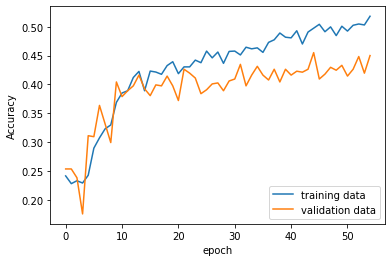

Accuracy of training set 0.548297
Accuracy of validation set 0.450085


In [172]:
#5 layers
model9 = models.Sequential()
model9.add(layers.Conv1D(filters=1024, kernel_size=5, activation='relu', padding='same', input_shape=(10,4)))
model9.add(layers.Conv1D(filters=512, kernel_size=4, padding='same', activation='relu'))
model9.add(layers.Dropout(0.5))
model9.add(layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model9.add(layers.Dropout(0.5))
model9.add(layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model9.add(layers.MaxPooling1D(pool_size=2))
model9.add(layers.Conv1D(filters=64, kernel_size=1, padding='same', activation='relu'))
model9.add(layers.Dropout(0.5))
model9.add(layers.Flatten())
model9.add(layers.Dense(100, activation='relu'))
model9.add(layers.Dense(6, activation='softmax'))
buildModelAndEvaluate(model9)

Models with 2 and 5 convolutional layers gave the best performance. I will explore if adding more dropout layers can reduce overfitting and thus improve model performance. 

Epoch 1/200
56/56 [==============================] - 3s 30ms/step - loss: 1.6166 - accuracy: 0.2362 - val_loss: 1.6263 - val_accuracy: 0.1878
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 2/200
56/56 [==============================] - 1s 25ms/step - loss: 1.5893 - accuracy: 0.2613 - val_loss: 1.5857 - val_accuracy: 0.3096
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 3/200
56/56 [==============================] - 1s 23ms/step - loss: 1.5494 - accuracy: 0.3222 - val_loss: 1.5076 - val_accuracy: 0.3266
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 4/200
56/56 [==============================] - 1s 22ms/step - loss: 1.4485 - accuracy: 0.3735 - val_loss: 1.4346 - val_accuracy: 0.3993
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 5/200
56/56 [==============================] - 1s 22ms/step - loss: 1.3825 - accuracy: 0.3925 - val_loss: 1.3859 - val_accuracy: 0

Epoch 39/200
56/56 [==============================] - 1s 21ms/step - loss: 1.0967 - accuracy: 0.5103 - val_loss: 1.2199 - val_accuracy: 0.4653
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 40/200
56/56 [==============================] - 1s 23ms/step - loss: 1.1046 - accuracy: 0.5187 - val_loss: 1.2501 - val_accuracy: 0.4179
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 41/200
56/56 [==============================] - 1s 23ms/step - loss: 1.0885 - accuracy: 0.5103 - val_loss: 1.2444 - val_accuracy: 0.4247
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 42/200
56/56 [==============================] - 1s 22ms/step - loss: 1.0879 - accuracy: 0.5036 - val_loss: 1.2365 - val_accuracy: 0.4484
INFO:tensorflow:Assets written to: model10_cnn1D_changedropout.hd5\assets
Epoch 43/200
56/56 [==============================] - 1s 23ms/step - loss: 1.0894 - accuracy: 0.5103 - val_loss: 1.2386 - val_accura

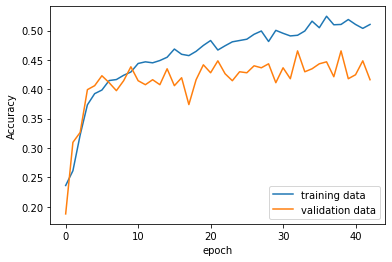

Accuracy of training set 0.514238
Accuracy of validation set 0.416244


In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#model with 2 layers
model10 = models.Sequential()
model10.add(layers.Conv1D(filters=512, kernel_size=4, activation='relu', padding='same', input_shape=(10,4)))
model10.add(layers.Dropout(0.5))
model10.add(layers.Conv1D(filters=256, kernel_size=2, padding='same', activation='relu'))
model10.add(layers.Dropout(0.5))
model10.add(layers.MaxPooling1D(pool_size=2))
model10.add(layers.Flatten())
model10.add(layers.Dense(100, activation='relu'))
model10.add(layers.Dense(6, activation='softmax'))
buildModelAndEvaluate(model10, 'model10_cnn1D_changedropout.hd5')

Epoch 1/200
56/56 [==============================] - 10s 164ms/step - loss: 1.6447 - accuracy: 0.2373 - val_loss: 1.6244 - val_accuracy: 0.1760
INFO:tensorflow:Assets written to: model11_cnn1D_changedropout.hd5\assets
Epoch 2/200
56/56 [==============================] - 8s 148ms/step - loss: 1.6146 - accuracy: 0.2345 - val_loss: 1.6098 - val_accuracy: 0.1760
INFO:tensorflow:Assets written to: model11_cnn1D_changedropout.hd5\assets
Epoch 3/200
56/56 [==============================] - 8s 146ms/step - loss: 1.6042 - accuracy: 0.2406 - val_loss: 1.5968 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model11_cnn1D_changedropout.hd5\assets
Epoch 4/200
56/56 [==============================] - 8s 147ms/step - loss: 1.5977 - accuracy: 0.2490 - val_loss: 1.5884 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model11_cnn1D_changedropout.hd5\assets
Epoch 5/200
56/56 [==============================] - 8s 141ms/step - loss: 1.5856 - accuracy: 0.2479 - val_loss: 1.5743 - val_accur

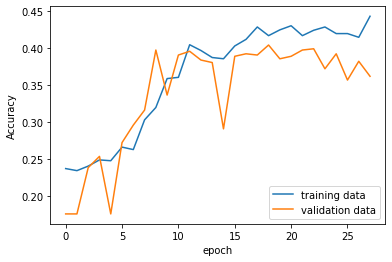

Accuracy of training set 0.409269
Accuracy of validation set 0.362098


In [27]:
#model with 5 layers
model11 = models.Sequential()
model11.add(layers.Conv1D(filters=1024, kernel_size=5, activation='relu', padding='same', input_shape=(10,4)))
model11.add(layers.Dropout(0.5))
model11.add(layers.Conv1D(filters=512, kernel_size=4, padding='same', activation='relu'))
model11.add(layers.Dropout(0.5))
model11.add(layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
model11.add(layers.Dropout(0.5))
model11.add(layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model11.add(layers.MaxPooling1D(pool_size=2))
model11.add(layers.Conv1D(filters=64, kernel_size=1, padding='same', activation='relu'))
model11.add(layers.Dropout(0.5))
model11.add(layers.Flatten())
model11.add(layers.Dense(100, activation='relu'))
model11.add(layers.Dense(6, activation='softmax'))
buildModelAndEvaluate(model11, 'model11_cnn1D_changedropout.hd5')

Adding more dropout layers seems to have a negative effect on model performance. 

Model with 2 layers seems to give a good performance but trains faster. I will use a model with 2 layers. Try again to increase number of filters to check if performance increases. I will be changing to odd kernel sizes. 

Epoch 1/200
56/56 [==============================] - 1s 17ms/step - loss: 1.6222 - accuracy: 0.2367 - val_loss: 1.6101 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 2/200
56/56 [==============================] - 1s 16ms/step - loss: 1.5884 - accuracy: 0.2462 - val_loss: 1.5754 - val_accuracy: 0.2741
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 3/200
56/56 [==============================] - 1s 16ms/step - loss: 1.5656 - accuracy: 0.2898 - val_loss: 1.5516 - val_accuracy: 0.2217
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 4/200
56/56 [==============================] - 1s 14ms/step - loss: 1.4683 - accuracy: 0.3451 - val_loss: 1.4119 - val_accuracy: 0.3926
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 5/200
56/56 [==============================] - 1s 15ms/step - loss: 1.3860 - accuracy: 0.3769 - val_loss: 1.3952 - val_acc

INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets


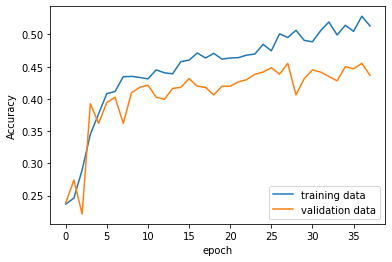

Accuracy of training set 0.533222
Accuracy of validation set 0.436548
Epoch 1/200
56/56 [==============================] - 6s 96ms/step - loss: 1.6152 - accuracy: 0.2362 - val_loss: 1.5869 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 2/200
56/56 [==============================] - 6s 107ms/step - loss: 1.5866 - accuracy: 0.2568 - val_loss: 1.6108 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 3/200
56/56 [==============================] - 5s 94ms/step - loss: 1.5331 - accuracy: 0.3155 - val_loss: 1.4786 - val_accuracy: 0.3553
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 4/200
56/56 [==============================] - 5s 96ms/step - loss: 1.4459 - accuracy: 0.3523 - val_loss: 1.4075 - val_accuracy: 0.3858
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 5/200
56/56 [==============================] - 5s 8

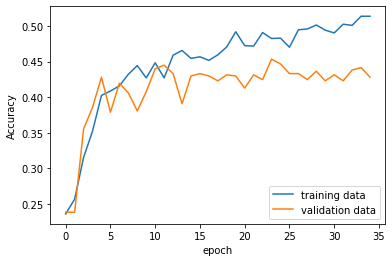

Accuracy of training set 0.545505
Accuracy of validation set 0.428088
Epoch 1/200
56/56 [==============================] - 7s 109ms/step - loss: 1.6120 - accuracy: 0.2641 - val_loss: 1.5867 - val_accuracy: 0.2487
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 2/200
56/56 [==============================] - 5s 94ms/step - loss: 1.5283 - accuracy: 0.3127 - val_loss: 1.4464 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 3/200
56/56 [==============================] - 6s 104ms/step - loss: 1.4248 - accuracy: 0.3769 - val_loss: 1.3749 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 4/200
56/56 [==============================] - 5s 99ms/step - loss: 1.3705 - accuracy: 0.4009 - val_loss: 1.3592 - val_accuracy: 0.4112
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 5/200
56/56 [==============================] - 6s 

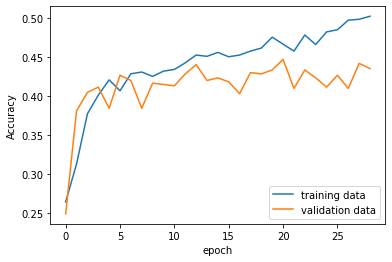

Accuracy of training set 0.524846
Accuracy of validation set 0.434856
Epoch 1/200
56/56 [==============================] - 13s 216ms/step - loss: 1.6233 - accuracy: 0.2457 - val_loss: 1.6122 - val_accuracy: 0.2792
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 2/200
56/56 [==============================] - 11s 206ms/step - loss: 1.5700 - accuracy: 0.2792 - val_loss: 1.4973 - val_accuracy: 0.3553
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 3/200
56/56 [==============================] - 11s 203ms/step - loss: 1.4537 - accuracy: 0.3596 - val_loss: 1.4552 - val_accuracy: 0.3536
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 4/200
56/56 [==============================] - 11s 202ms/step - loss: 1.3963 - accuracy: 0.3646 - val_loss: 1.3874 - val_accuracy: 0.3858
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 5/200
56/56 [==============================]

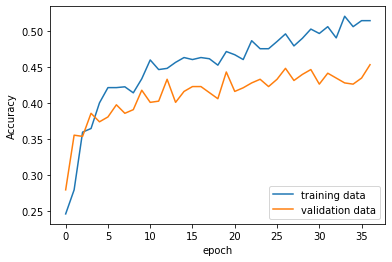

Accuracy of training set 0.541597
Accuracy of validation set 0.453469
Epoch 1/200
56/56 [==============================] - 30s 523ms/step - loss: 1.6195 - accuracy: 0.2406 - val_loss: 1.6031 - val_accuracy: 0.2386
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 2/200
56/56 [==============================] - 29s 521ms/step - loss: 1.5675 - accuracy: 0.2803 - val_loss: 1.5298 - val_accuracy: 0.2538
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 3/200
56/56 [==============================] - 28s 508ms/step - loss: 1.4375 - accuracy: 0.3646 - val_loss: 1.3733 - val_accuracy: 0.3807
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 4/200
56/56 [==============================] - 25s 455ms/step - loss: 1.3623 - accuracy: 0.3964 - val_loss: 1.3623 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model12_cnn1D_increasefilters.hd5\assets
Epoch 5/200
56/56 [==============================]

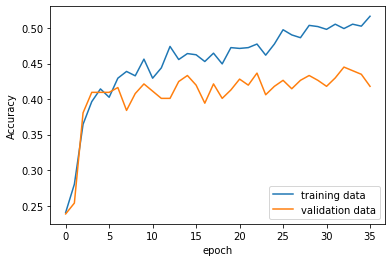

Accuracy of training set 0.537688
Accuracy of validation set 0.417936


In [29]:
#model with 2 layers
filters_lst = [[512, 256], [768, 384], [1024, 512], [1536, 768], [2048, 1024]]

for duo in filters_lst:
    
    model12 = models.Sequential()
    model12.add(layers.Conv1D(filters=duo[0], kernel_size=5, activation='relu', padding='same', input_shape=(10,4)))
    model12.add(layers.Dropout(0.5))
    model12.add(layers.Conv1D(filters=duo[1], kernel_size=3, padding='same', activation='relu'))
    model12.add(layers.MaxPooling1D(pool_size=2))
    model12.add(layers.Flatten())
    model12.add(layers.Dense(100, activation='relu'))
    model12.add(layers.Dense(6, activation='softmax'))
    buildModelAndEvaluate(model12, 'model12_cnn1D_increasefilters.hd5')

[768, 384] seems to give the best results. I will try different optimisers next. 

In [31]:
model13 = models.Sequential()
model13.add(layers.Conv1D(filters=768, kernel_size=5, activation='relu', padding='same', input_shape=(10,4)))
model13.add(layers.Dropout(0.5))
model13.add(layers.Conv1D(filters=384, kernel_size=3, padding='same', activation='relu'))
model13.add(layers.MaxPooling1D(pool_size=2))
model13.add(layers.Flatten())
model13.add(layers.Dense(100, activation='relu'))
model13.add(layers.Dense(6, activation='softmax'))

Epoch 1/200
56/56 [==============================] - 4s 69ms/step - loss: 1.1511 - accuracy: 0.4897 - val_loss: 1.3436 - val_accuracy: 0.3909
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 2/200
56/56 [==============================] - 4s 69ms/step - loss: 1.1635 - accuracy: 0.4712 - val_loss: 1.3238 - val_accuracy: 0.4146
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 3/200
56/56 [==============================] - 4s 66ms/step - loss: 1.1494 - accuracy: 0.4925 - val_loss: 1.3358 - val_accuracy: 0.4095
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 4/200
56/56 [==============================] - 4s 70ms/step - loss: 1.1797 - accuracy: 0.4584 - val_loss: 1.3258 - val_accuracy: 0.4044
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 5/200
56/56 [==============================] - 4s 67ms/step - loss: 1.1691 - accuracy: 0.4724 - val_loss: 1.3451 - val_accuracy: 0.4061
INFO:t

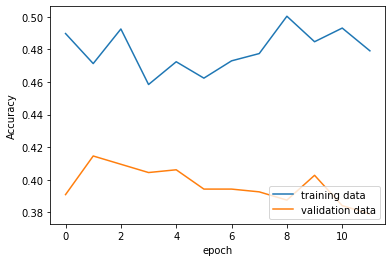

current optimiser is <keras.optimizer_v2.gradient_descent.SGD object at 0x00000197E1E4A0F0>
Accuracy of training set 0.451145
Accuracy of validation set 0.379019
Epoch 1/200
56/56 [==============================] - 6s 101ms/step - loss: 1.2585 - accuracy: 0.4372 - val_loss: 1.3305 - val_accuracy: 0.3790
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 2/200
56/56 [==============================] - 5s 90ms/step - loss: 1.3096 - accuracy: 0.4355 - val_loss: 1.4703 - val_accuracy: 0.3249
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 3/200
56/56 [==============================] - 5s 89ms/step - loss: 1.3132 - accuracy: 0.4271 - val_loss: 1.3770 - val_accuracy: 0.3621
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 4/200
56/56 [==============================] - 5s 98ms/step - loss: 1.2769 - accuracy: 0.4405 - val_loss: 1.3575 - val_accuracy: 0.3655
INFO:tensorflow:Assets written to: model13_cnn1D_optimis

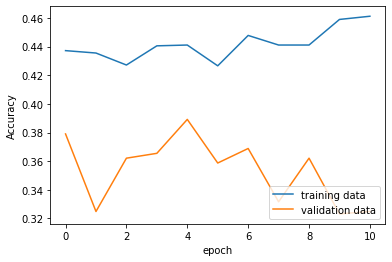

current optimiser is <keras.optimizer_v2.rmsprop.RMSprop object at 0x00000197E1E4A128>
Accuracy of training set 0.395868
Accuracy of validation set 0.324873
Epoch 1/200
56/56 [==============================] - 4s 65ms/step - loss: 1.2445 - accuracy: 0.4489 - val_loss: 1.4025 - val_accuracy: 0.3739
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 2/200
56/56 [==============================] - 4s 65ms/step - loss: 1.2033 - accuracy: 0.4685 - val_loss: 1.4048 - val_accuracy: 0.3689
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 3/200
56/56 [==============================] - 4s 67ms/step - loss: 1.2067 - accuracy: 0.4578 - val_loss: 1.4179 - val_accuracy: 0.3621
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 4/200
56/56 [==============================] - 4s 69ms/step - loss: 1.1895 - accuracy: 0.4735 - val_loss: 1.4015 - val_accuracy: 0.3723
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd

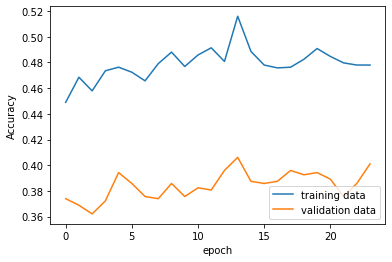

current optimiser is <keras.optimizer_v2.adam.Adam object at 0x00000197E1E4AE48>
Accuracy of training set 0.455053
Accuracy of validation set 0.401015
Epoch 1/200
56/56 [==============================] - 7s 108ms/step - loss: 1.1594 - accuracy: 0.4807 - val_loss: 1.3632 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 2/200
56/56 [==============================] - 6s 104ms/step - loss: 1.1400 - accuracy: 0.4925 - val_loss: 1.3633 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 3/200
56/56 [==============================] - 6s 100ms/step - loss: 1.1441 - accuracy: 0.4958 - val_loss: 1.3634 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 4/200
56/56 [==============================] - 6s 107ms/step - loss: 1.1524 - accuracy: 0.4897 - val_loss: 1.3634 - val_accuracy: 0.4010
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\

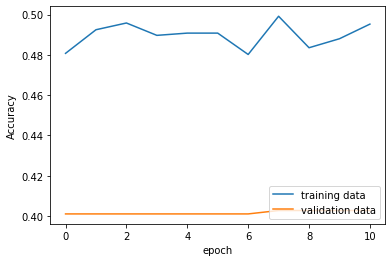

current optimiser is <keras.optimizer_v2.adadelta.Adadelta object at 0x00000197E1E4A0B8>
Accuracy of training set 0.452261
Accuracy of validation set 0.402707
Epoch 1/200
56/56 [==============================] - 7s 106ms/step - loss: 1.1446 - accuracy: 0.5025 - val_loss: 1.3707 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 2/200
56/56 [==============================] - 5s 97ms/step - loss: 1.1691 - accuracy: 0.4919 - val_loss: 1.3702 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 3/200
56/56 [==============================] - 6s 102ms/step - loss: 1.1357 - accuracy: 0.4869 - val_loss: 1.3694 - val_accuracy: 0.4061
INFO:tensorflow:Assets written to: model13_cnn1D_optimisers.hd5\assets
Epoch 4/200
56/56 [==============================] - 6s 99ms/step - loss: 1.1616 - accuracy: 0.4858 - val_loss: 1.3709 - val_accuracy: 0.4078
INFO:tensorflow:Assets written to: model13_cnn1D_optimiser

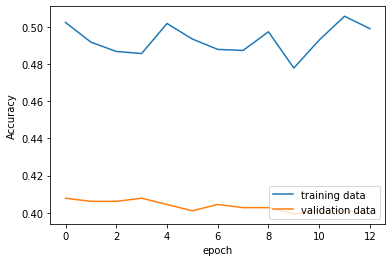

current optimiser is <keras.optimizer_v2.adagrad.Adagrad object at 0x00000197E20B13C8>
Accuracy of training set 0.443886
Accuracy of validation set 0.399323


In [34]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adagrad

#list of optimisers
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False)
rmsprop = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.9,epsilon=1e-07,centered=True)
adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
adadelta = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07)
adagrad = Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07)

optimiserlist = [sgd, rmsprop, adam, adadelta, adagrad]

for opt in optimiserlist:
    
    model13.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    MODEL_NAME13 = 'model13_cnn1D_optimisers.hd5'
    savemodel = ModelCheckpoint(MODEL_NAME13)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)
    
    learning_model13 = model13.fit(Xtrain, ytrain, epochs=200, batch_size=32, validation_data=(Xval,yval), callbacks=[savemodel, stopmodel])
    
    #plot graphs
    plt.plot(learning_model13.history['accuracy'])
    plt.plot(learning_model13.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['training data', 'validation data'], loc='lower right')
    plt.show()
    
    print(f"current optimiser is {opt}")
    
    #print accuracy 
    #training set 
    trainPredict = model13.predict(Xtrain)
    trainPredict = mapResultsToClass(trainPredict)
    trainAccuracy = accuracy_score(ytrain, trainPredict)
    print("Accuracy of training set %f" % trainAccuracy)

    #validation set 
    valPredict = model13.predict(Xval)
    valPredict = mapResultsToClass(valPredict)
    valAccuracy = accuracy_score(yval, valPredict)
    print("Accuracy of validation set %f" % valAccuracy)


Adadelta and Adam seems to give good performance. I will stick to Adam. 

In [38]:
#build model
model14 = models.Sequential()
model14.add(layers.Conv1D(filters=768, kernel_size=5, 
                          activation='relu', padding='same', 
                          input_shape=(10,4)))
model14.add(layers.Dropout(0.5))
model14.add(layers.Conv1D(filters=384, kernel_size=3, 
                          padding='same', activation='relu'))
model14.add(layers.MaxPooling1D(pool_size=2))
model14.add(layers.Flatten())
model14.add(layers.Dense(100, activation='relu'))
model14.add(layers.Dense(6, activation='softmax'))

#compile
adam = Adam(learning_rate=0.001,beta_1=0.9,
            beta_2=0.999,epsilon=1e-07,amsgrad=False)
model14.compile(loss='sparse_categorical_crossentropy', 
                optimizer=adam, metrics=['accuracy'])

#fit and save
MODEL_NAME14 = 'model14_cnn1D_final.hd5'
savemodel = ModelCheckpoint(MODEL_NAME14)
stopmodel = EarlyStopping(min_delta=0.001, patience=10)
    
learning_model14 = model14.fit(Xtrain, ytrain, epochs=300, batch_size=32, validation_data=(Xval,yval), callbacks=[savemodel, stopmodel])

Epoch 1/300
56/56 [==============================] - 7s 107ms/step - loss: 1.6224 - accuracy: 0.2345 - val_loss: 1.6180 - val_accuracy: 0.2030
INFO:tensorflow:Assets written to: model14_cnn1D_final.hd5\assets
Epoch 2/300
56/56 [==============================] - 6s 105ms/step - loss: 1.5918 - accuracy: 0.2792 - val_loss: 1.5778 - val_accuracy: 0.2673
INFO:tensorflow:Assets written to: model14_cnn1D_final.hd5\assets
Epoch 3/300
56/56 [==============================] - 6s 109ms/step - loss: 1.5261 - accuracy: 0.3305 - val_loss: 1.4661 - val_accuracy: 0.3841
INFO:tensorflow:Assets written to: model14_cnn1D_final.hd5\assets
Epoch 4/300
56/56 [==============================] - 6s 102ms/step - loss: 1.4290 - accuracy: 0.3624 - val_loss: 1.4101 - val_accuracy: 0.3655
INFO:tensorflow:Assets written to: model14_cnn1D_final.hd5\assets
Epoch 5/300
56/56 [==============================] - 6s 102ms/step - loss: 1.3886 - accuracy: 0.3864 - val_loss: 1.3661 - val_accuracy: 0.3841
INFO:tensorflow:Asset

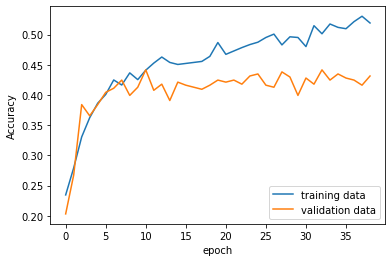

In [39]:
#plot graphs
plt.plot(learning_model14.history['accuracy'])
plt.plot(learning_model14.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()

In [40]:
#print accuracy 
    
#training set 
trainPredict = model14.predict(Xtrain)
trainPredict = mapResultsToClass(trainPredict)
trainAccuracy = accuracy_score(ytrain, trainPredict)
print("Accuracy of training set %f" % trainAccuracy)

#validation set 
valPredict = model14.predict(Xval)
valPredict = mapResultsToClass(valPredict)
valAccuracy = accuracy_score(yval, valPredict)
print("Accuracy of validation set %f" % valAccuracy)

#test set 
testPredict = model14.predict(Xtest)
testPredict = mapResultsToClass(testPredict)
testAccuracy = accuracy_score(ytest, testPredict)
print("Accuracy of test set %f" % testAccuracy)

Accuracy of training set 0.563372
Accuracy of validation set 0.431472
Accuracy of test set 0.458545
